Authors: Cynarski Michał & Barszczak Bartłomiej
AGH WEAIiIB AIR-ISZ

# Bayesian models for predicting the number of fatalities in terrorist attacks using GTD data.

#### Libraries import

In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import networkx as nx

SEED = 123
SAMPLES_SIZE = 1000

MODEL_1_ROOT = "model1/"
MODEL_PATH_1 = MODEL_1_ROOT + "code1.stan"
MODEL_PATH_1_PPC = MODEL_1_ROOT + "code1_ppc.stan"

MODEL_2_ROOT = "model2/"
MODEL_PATH_2 = MODEL_2_ROOT + "code2.stan"
MODEL_PATH_2_PPC = MODEL_2_ROOT + "code2_ppc.stan"

GTD_DATA_PATH = "data/globalterrorismdb_0718dist.csv"

In [2]:
def scatter_hist_display(val_mat, y_values):
    fig, axs = plt.subplots(2, len(val_mat.columns), dpi=300)
    fig.set_size_inches(5*len(val_mat.columns), 10)

    for i, col in enumerate(val_mat.columns):
        axs[0, i].scatter(val_mat[col], y_values)
        axs[0, i].set_title(col)
        axs[0, i].set_ylabel(y_values.name)
        axs[0, i].grid()

        axs[1, i].hist(val_mat[col])
        axs[1, i].set_ylabel("Density")
        axs[1, i].set_xlabel(col)
        axs[1, i].grid()

def hist_compare(y_real, y_gen):
    plt.figure(dpi=150)
    max_val = int(max(y_real.max(), y_gen.max())) + 1
    bins = range(0, max_val + 1)
    y_real.hist(alpha=0.5, label="Real", bins=bins)
    y_gen.hist(alpha=0.5, label="Generated", bins=bins)
    plt.legend()
    plt.title("Generated samples")
    plt.xlabel(y_real.name)
    plt.xlim(0,20)
    plt.grid()
    plt.show()

def scatter_compare_display(val_mat, y_values_orig, y_values_gen):
    fig, axs = plt.subplots(1, len(val_mat.columns), dpi=300)
    fig.set_size_inches(5 * len(val_mat.columns), 5)

    for i, col in enumerate(val_mat.columns):
        axs[i].scatter(val_mat[col], y_values_orig, alpha=0.8, label="Original")
        axs[i].scatter(val_mat[col], y_values_gen, alpha=0.8, label="Generated")
        axs[i].set_title(col)
        axs[i].set_ylabel(y_values_orig.name)
        axs[i].set_xlabel(col)
        axs[i].grid()
        axs[i].legend()

def hist_distr_display(df_var, second_model=False):
    fig, ax = plt.subplots(2, 3, dpi=300)
    fig.set_size_inches(15, 10)

    if second_model:
        priors = ["alpha", 'beta_cont', 'beta_weaptype', 'beta_targtype', 'beta_country', 'phi']
    else:
        priors = ["alpha", 'beta_cont', 'beta_weaptype', 'beta_targtype', 'beta_country']
    
    for i, col in enumerate(priors):
        if col == "alpha" or col == "phi":
            reg = f"^{col}$"
            ax[i//3, i%3].hist(df_var[list(df_var.filter(regex=reg).columns)])
            ax[i//3, i%3].set_ylabel("Density")
            ax[i//3, i%3].set_title(col)
            ax[i//3, i%3].grid()
        elif col == "beta_cont":
            reg = f"{col}\[\d+\]"
            ax[i//3, i%3].hist(df_var[list(df_var.filter(regex=reg).columns)])
            ax[i//3, i%3].set_ylabel("Density")
            ax[i//3, i%3].set_title(col)
            ax[i//3, i%3].grid()
        else:
            reg = f"{col}\[\d+\]"
            ax[i//3, i%3].hist(df_var[list(df_var.filter(regex=reg).columns)].mean())
            ax[i//3, i%3].set_ylabel("Density")
            ax[i//3, i%3].set_title(f"{col} (mean)")
            ax[i//3, i%3].grid()
    
    plt.show()

def hist_disr_posterior_display(sim, second_model=False):
    fig, ax = plt.subplots(2, 3, figsize=(15, 10), dpi=300)

    if second_model:
        priors = ["alpha", "beta_cont", "beta_weaptype", "beta_targtype", "beta_country", "phi"]
    else:
        priors = ["alpha", "beta_cont", "beta_weaptype", "beta_targtype", "beta_country"]

    for i, item in enumerate(priors):
        if item in ["alpha", "beta_cont", "phi"]:
            var = sim.stan_variable(item)
            ax[i // 3, i % 3].set_title(f'Histogram of {item}')
        else:
            var = sim.stan_variable(item)
            var = np.mean(var, axis=1)
            ax[i // 3, i % 3].set_title(f'Histogram of {item} (mean)')
            
        ax[i // 3, i % 3].hist(var, bins=30, density=True)
        ax[i // 3, i % 3].set_xlabel(item)
        ax[i // 3, i % 3].grid()

    plt.show()


def display_dag():
    G = nx.DiGraph()

    nodes = ['country', 'weapon type', 'target type', 'nperps', 'nkill']
    G.add_nodes_from(nodes)
    
    edges = [
        ('country', 'target type'),
        ('weapon type', 'target type'),
        ('target type', 'nkill'),
        ('nperps', 'nkill')
    ]
    G.add_edges_from(edges)
    
    plt.figure(figsize=(10, 8))
    
    pos = {
        'country': (0, 1),
        'weapon type': (0, -1),
        'target type': (2, 0),
        'nperps': (3, -1),
        'nkill': (4, 0)
    }
    
    nx.draw(G, pos, 
            with_labels=True, 
            node_color='lightblue', 
            node_size=6000,
            font_size=12,
            font_weight='bold',
            arrows=True,
            arrowsize=20,
            arrowstyle='simple',
            edge_color='gray',
            width=2)

    plt.grid(True, alpha=0.3)
    plt.show()

## 1. Prolem formulation

What does a terrorist attack depend on and how many victims can it claim? This was the clue and starting point of our project. Instead of focusing on terrorism as social or political aspect, we focused on pure analyze of the attacks' data. To be more precise, we tried to predict the number of victims based on specific characteristics of an incident.

The Bayesian models developed and the results achieved can help analysts and decision-makers grasp the extent to which various features of terrorist acts affect the number of victims. A method to find at least partial answers to the question “What is the number of potentially lost lives if certain attack methods, targets, or geographic contexts are chosen?” is provided by this project.

Utilizing these models on the Global Terrorism Database, we exhibit the ability to predict victim numbers for the conditions that prevail, as depicted in the dataset. It should be noted that our study is based on data of incidents from all over the globe, and that differences from one region to another in tactics, security, and the way incidents are reported might cause the models to perform less well in some areas compared to others.

Futhermore, the number of victims of the attack cannot be simply predicted. There are some obviousness that, for example, bomb can kill more people than knife, but this is a rather more complex problem that we have taken upon our honor to investigate.

Below is a visible DAG diagram for our project.

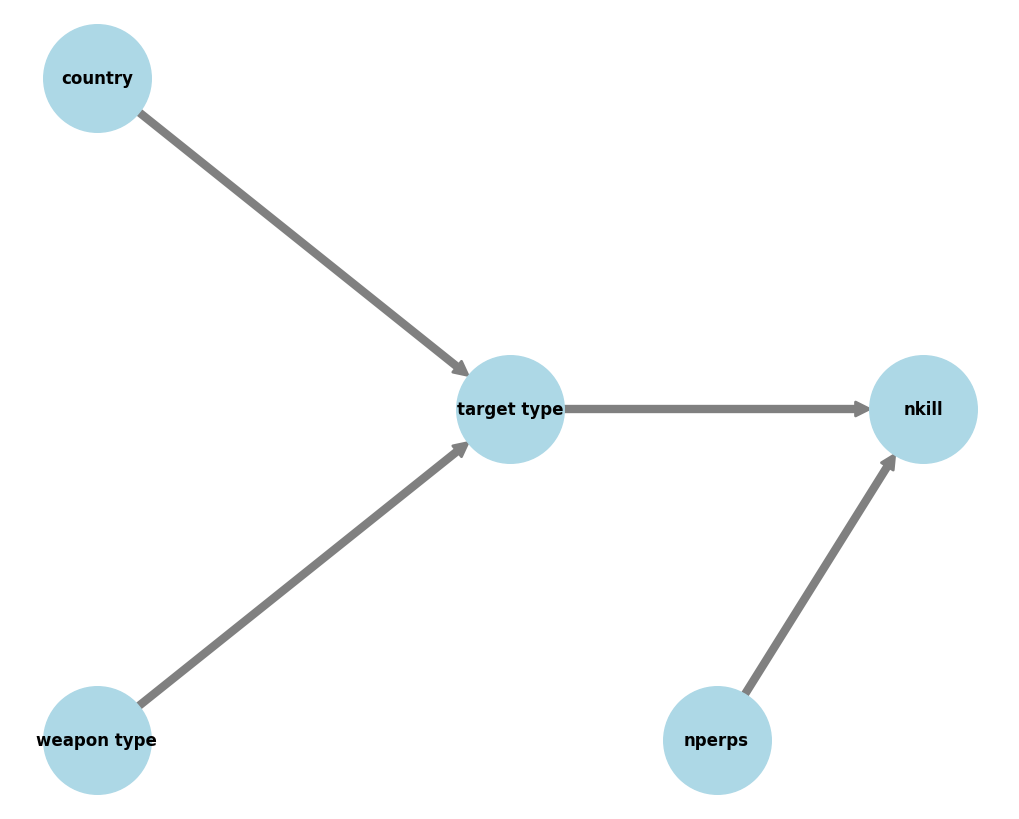

In [3]:
display_dag()

## 2. Data preprocessing

The data we used in our project is from Global Terrorism Database (GTB). It is opensource database created by researchers at University of Maryland, who obtained a large database originally collected by the Pinkerton Global Intelligence Services. Database contains records of almost all terrorism attacks from years 1970 to 2017 except year 1993. Records from 1993 are missing because of PGIS office move (error during file migration process), and these data have never been fully recovered. Database contains 135 columns in total, which describe attack, for example weapon type, date of attacks, country, target and many more.

In [4]:
df = pd.read_csv(GTD_DATA_PATH, encoding='latin-1', low_memory=False)
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


Not all records have fulfilled all variables, but the most wanted columns like country or number of attackers was filled.
Because of that, the database needs to be preprocessed. The preprocessing takes several steps.
First step was to take the columns that we proposed and have the biggest impact in number of victims, and drop the records where were missing values.
Next step was filter out the records where the nperps column is positive. Some records contain information that number of attackers is -99.
This does not mean that -99 attackers took place in attack, but the value is missing.
A further step was to take random sample of 1000 records from cleared dataframe.

In [5]:
categorical_columns = ['weaptype1_txt', 'targtype1_txt', 'country_txt']
predictors = categorical_columns + ['nperps']
selected_columns = ['nkill'] + predictors
df = df[selected_columns].dropna()
df = df[df['nperps'] > 0 ]
df = df[df['nperps'] < 1000 ]


df = df.sample(n=SAMPLES_SIZE, random_state=SEED)
print(len(df), "rows in the dataset after filtering")
df.head()

1000 rows in the dataset after filtering


,nkill,weaptype1_txt,targtype1_txt,country_txt,nperps
151292,0.0,Firearms,Military,Colombia,1.0
129815,3.0,Incendiary,Private Citizens & Property,Nigeria,50.0
159022,0.0,Explosives,Transportation,India,3.0
102638,2.0,Firearms,Private Citizens & Property,India,5.0
91299,0.0,Explosives,Educational Institution,India,50.0


Another step was encoding the data which are categorical. In our case these columns are: weaptype1_txt, targtype1_txt, country_txt.
We decided to consider the nperps as continous data. 

In [6]:
for column in categorical_columns:
    le = LabelEncoder()
    df[column.replace("txt", "encoded")] = le.fit_transform(df[column]) + 1

The last step was to create new dataframe without nkill column, and normalize it. 
Normalization was performed by subtracting the mean and dividing by the standard deviation.

In [7]:
selected_columns = ["weaptype1_encoded", "targtype1_encoded", "country_encoded", "nperps"]
df_data = df[selected_columns]

weaptype1 = df['weaptype1_encoded'].values
targtype1 = df['targtype1_encoded'].values
country = df['country_encoded'].values
X_cont = df['nperps']
X_cont = ((X_cont - X_cont.mean()) / X_cont.std()).values
nkill = df['nkill'].values

df2 = df[['nkill', 'weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']]

stan_data_pcc = {
        'N': len(df),
        'K_cont': 1,
        'K_weaptype': int(weaptype1.max()),
        'K_targtype': int(targtype1.max()),
        'K_country': int(country.max()),
        'X_cont': X_cont.reshape(-1, 1),
        'weaptype': weaptype1.tolist(),
        'targtype': targtype1.tolist(),
        'country': country.tolist()
}

stan_data = {
        'N': len(df),
        'K_cont': 1,                         # 1 since we got only 1 column
        'K_weaptype': int(weaptype1.max()),  # number of weapon types
        'K_targtype': int(targtype1.max()),  # number of target types
        'K_country': int(country.max()),     # number of countries
        'X_cont': X_cont.reshape(-1, 1),
        'weaptype': weaptype1.tolist(),
        'targtype': targtype1.tolist(),
        'country': country.tolist(),
        'nkill': np.array(nkill, dtype=int).tolist()
}

display(df2)

,nkill,weaptype1_encoded,targtype1_encoded,country_encoded,nperps
151292,0.0,4,10,17,1.0
129815,3.0,5,14,60,50.0
159022,0.0,2,19,35,3.0
102638,2.0,4,14,35,5.0
91299,0.0,2,4,35,50.0
...,...,...,...,...,...
156021,1.0,4,7,1,1.0
55894,1.0,6,10,40,1.0
97514,2.0,4,17,38,4.0
166044,6.0,2,10,1,6.0


## 3. Model

Before discussing model creation, we decided to analyze the data once more and visualize it.

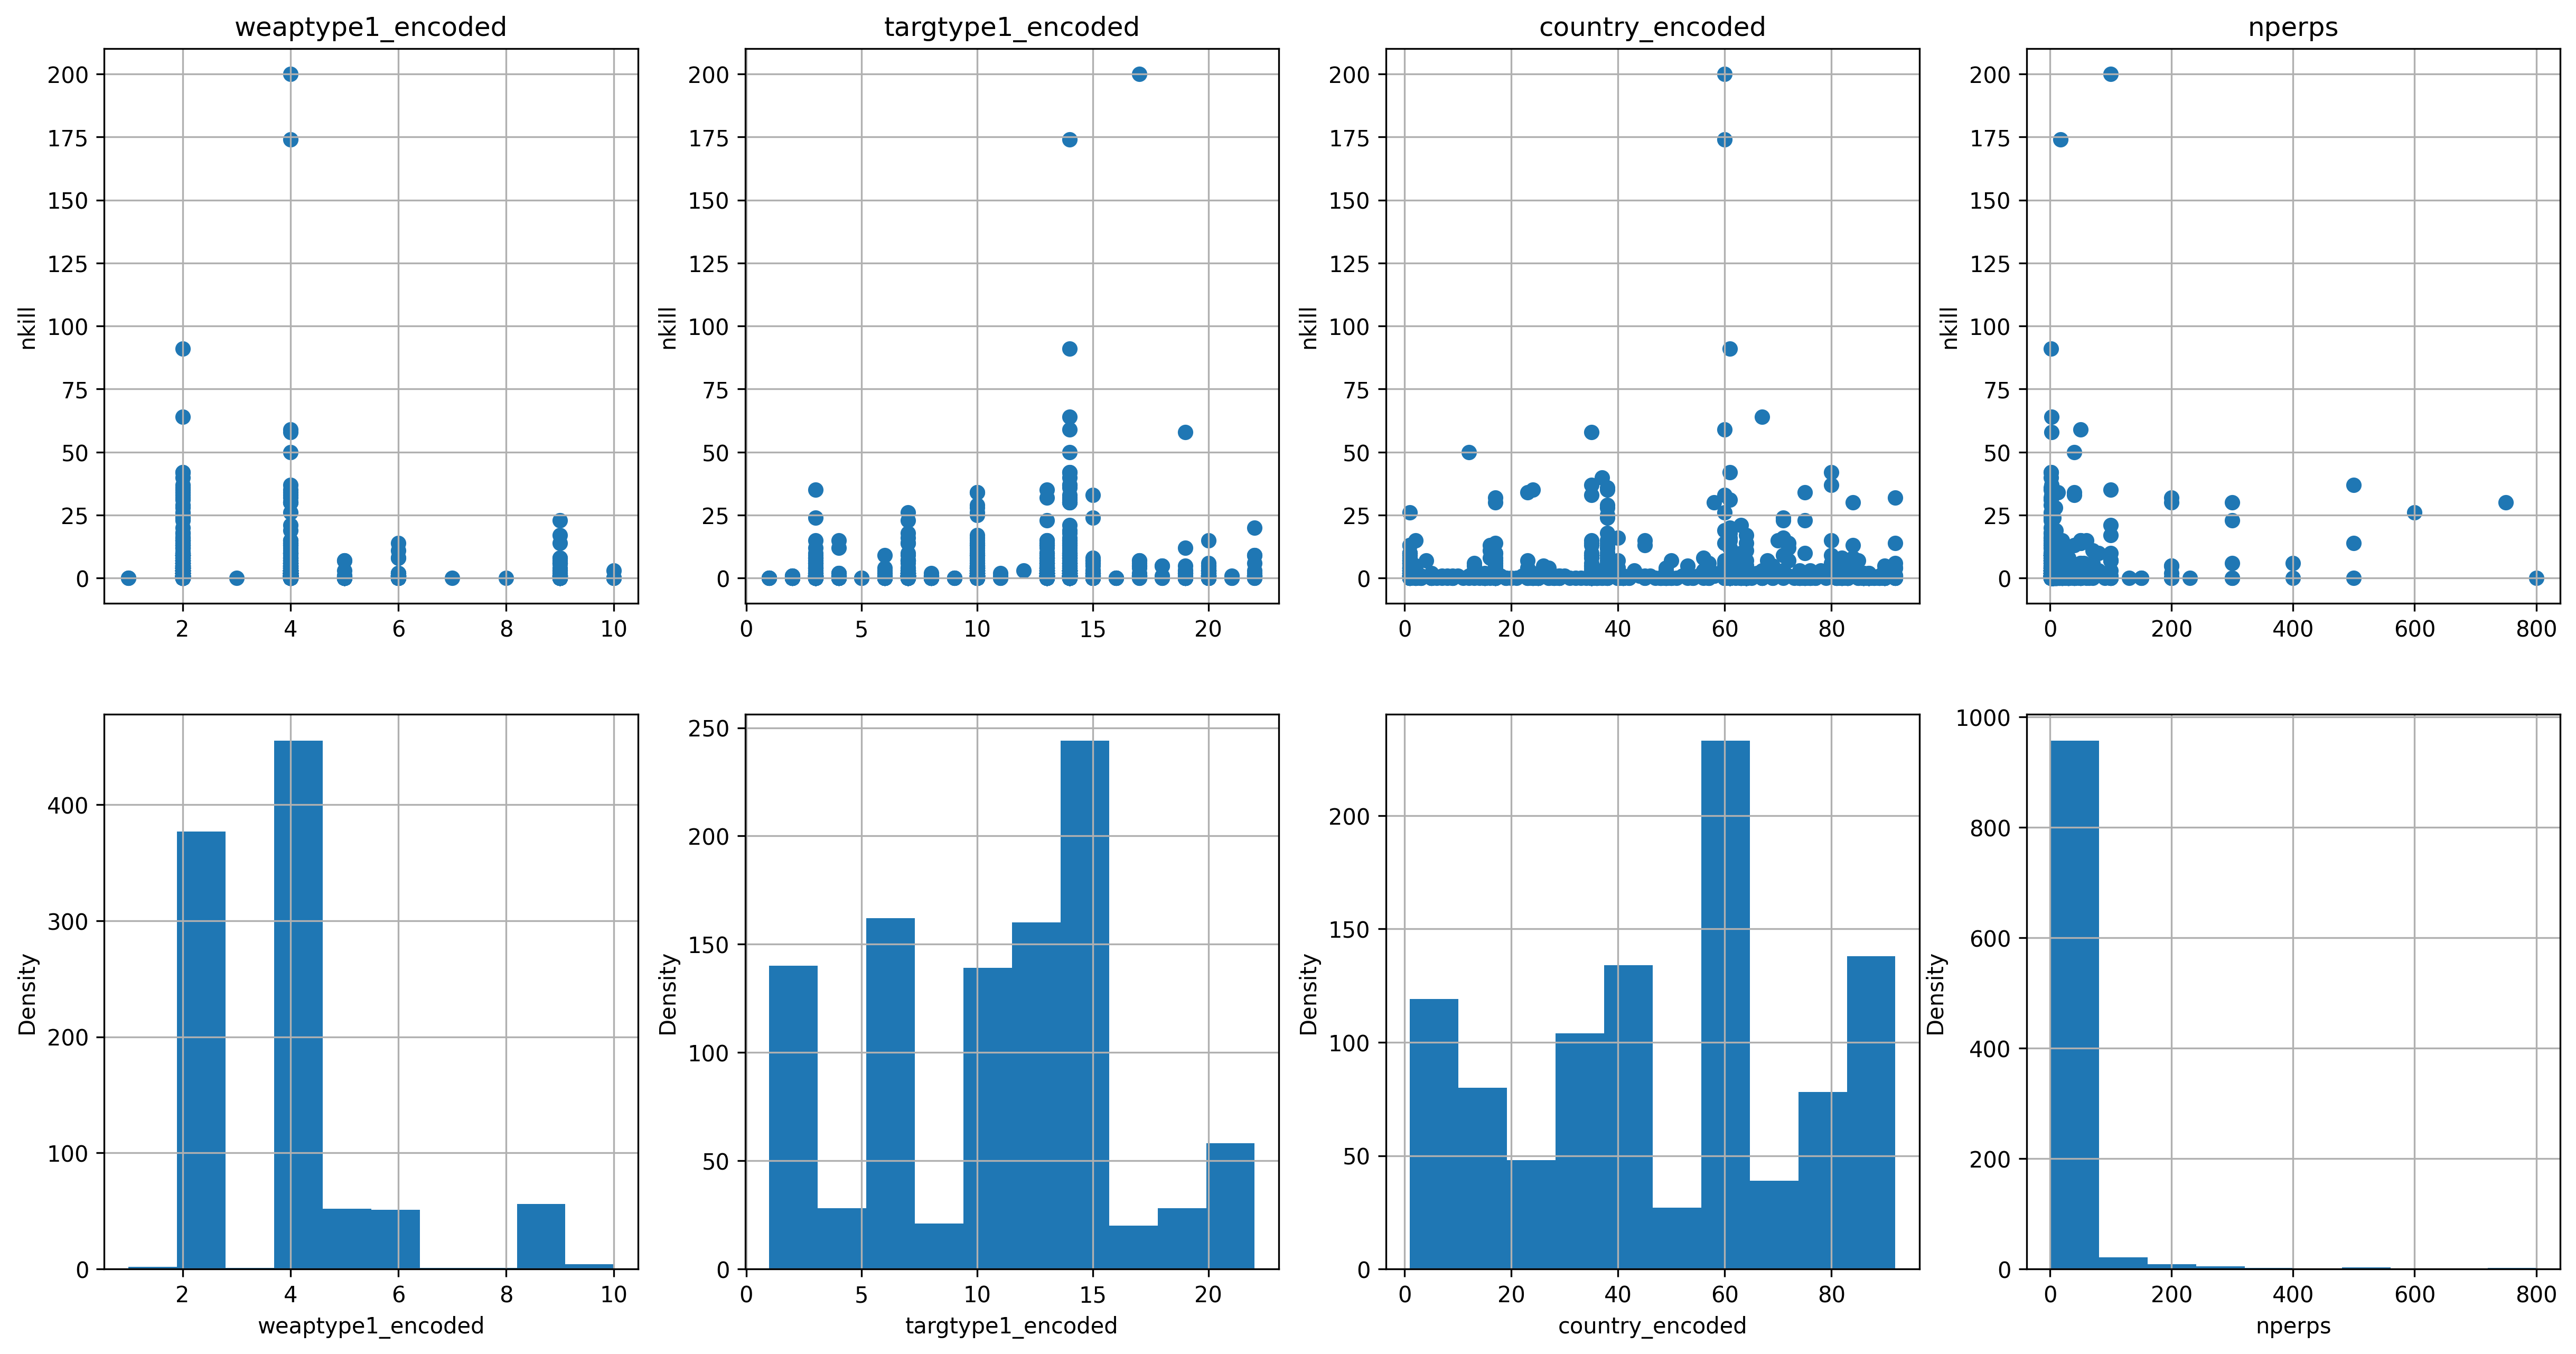

In [8]:
scatter_hist_display(df2[['weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']], df2["nkill"])

The above plots presents that there is no clear linear relationship between number of victims and the other features. This could be due to categorical variables. The data visualized at the charts shows that most of the attacks took place using bombing/explosions or with guns. Also, these kinds of attacks have the most impact in the number of victims in single attack. What's more in most of the attacks involved less than 250 attackers.

Based on these observations, we decided to use more complex model, which is more suitable for this problem than simple linear models.

The first model is Poisson regression model with log link function.
The log link function is a sum of parameter alpha, a linear combination of set X, which is continous data, multiplied by corresponding factor beta_cont and corresponding to weapon type, target type and country beta weights. To be more precise, each categorical column has it's own beta weights.
Then the actual Poisson log regresion is used.
The first model include the following predictors: encoded weapon type, encoded target type, encoded country and number of attackers. 
These predictors were selected based on articles found on the Internet. What's more, these predictors capture the core dynamics of an attack, its method (weapon type), intended target (target type), scale (number of attackers - nperps), and country, making them influential for estimating its potential lethality.

Second model is similar to the first model. 
Second model uses a negative binomial likelihood instead of Poisson distribution. 
A negative binomial model is more appropriate than a Poisson when we want to model attack kills as it is capable of accommodating the overdispersion (extremely variable counts with many zeros and few very large numbers) which is the characteristic of terrorism data, thus resulting in estimates that are more accurate and true to nature.
Likewise to first model, this also uses all the predictors.

## 4. Priors

The selected priors for the models are the parameters Alpha, Beta and a prior for the standard deviation Phi.
For Alpha, Beta, a normal distribution was selected as the prior because we do not have any expertise knowledge suggesting the use of a better more specialized distribution.
For the Phi parameter, we selected an exponential distribution because it is often used with negative binomial models.

For these models we selected specific values based on our knowledge and have strong impact on each predictor on the outcome.

For the first model, the priors are selected with use of a Poisson-log link: 

$log(\lambda_n) = \alpha + X_{cont}[n]\beta_{cont} + \beta_{weaptype}[n] + \beta_{targtype}[n] + \beta_{country}[n]$.

The intercept ($\alpha$) has a Normal(3.5, 1.25) prior, indicating that the prior belief about the average attack rate is that it is centered around 3.5 with a standard deviation of 1.25. 
The continuous covariate coefficients ($\beta_{cont}$) are given the Normal(0.05, 0.25) priors that mean an effect of a small size, which is slightly off the zero. 
The weapon-type effects ($\beta_{weaptype}$) are given Normal(0.5, 0.5) priors that give them a chance to be of the size we specified range. 
Target-type effects ($\beta_{targtype}$) use Normal(0.15, 0.5) priors which mean that the character of the target will not change much, while at the same time being quite unsure about this change.
Along the same lines, the country effects ($\beta_{country}$) have Normal(0.15, 0.5) priors which illustrate that the diversity of the countries is depicted by a moderate amount of variance of the prior distribution.
These values are based on our current knowledge of the discussed domain and determine the impact of each predictor on the final outcome.

For the second model, the selected priors are almost the same except one change. The normal distribution was changed to student-t distribution with the same mean and standard diviation, and the $\nu$ set to 10.
We decided to that change, because student-t distributions have heavier tails than normal distributions, as a result they are more tolerant of extreme coefficient values.

#### Model 1

In [29]:
model1_ppc = CmdStanModel(stan_file=MODEL_PATH_1_PPC)
sim1_ppc = model1_ppc.sample(
    data=stan_data_pcc,
    seed=SEED,
    chains=4,
    iter_sampling=1000,
    iter_warmup=1000
)

df_1_ppc = sim1_ppc.draws_pd()
offset = 10 + 1 + 1 + int(weaptype1.max()) + int(targtype1.max()) + int(country.max())

08:29:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:29:04 - cmdstanpy - INFO - CmdStan done processing.


In [55]:
data = np.round(df_1_ppc.iloc[:, offset:SAMPLES_SIZE+offset].mean())
data = data[data < 1000].to_list()
while len(data) < 1000:
    data.append(0)

data = pd.Series(data, dtype=int)
# display(data)


In [10]:
display(df_1_ppc)

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,log_lambda_prior[991],log_lambda_prior[992],log_lambda_prior[993],log_lambda_prior[994],log_lambda_prior[995],log_lambda_prior[996],log_lambda_prior[997],log_lambda_prior[998],log_lambda_prior[999],log_lambda_prior[1000]
0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,1.11997,1.230900,0.098742,1.28045,1.064680,0.505963,1.77282,-0.576935,2.10283,1.88257
1,1.0,2.0,2.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,3.65928,2.430960,2.198630,3.69277,3.985700,3.010960,3.40564,3.220700,3.13635,3.94060
2,1.0,3.0,3.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,3.82727,4.736070,4.043530,3.32888,4.269080,4.176400,2.99740,4.609280,3.52527,3.64821
3,1.0,4.0,4.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,3.46994,1.939320,2.735470,6.03460,2.096310,3.113510,1.09449,2.679950,2.47722,4.30127
4,1.0,5.0,5.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.42545,4.946570,3.146470,5.72726,3.630600,3.487430,3.57300,4.473170,5.32880,5.04011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,3.79617,3.474870,2.987280,3.64012,2.816000,3.893410,3.03400,3.215310,4.00250,4.14318
3996,4.0,997.0,3997.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.83573,4.523190,2.977340,3.34799,3.505020,3.748190,3.06968,5.377130,4.20226,5.03945
3997,4.0,998.0,3998.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.00092,0.934873,2.252990,3.57184,0.996818,1.225620,2.01963,0.549563,2.52000,3.37275
3998,4.0,999.0,3999.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,...,4.83452,5.790300,5.140040,4.76002,3.209980,4.184950,3.73312,4.553050,3.73235,5.51369


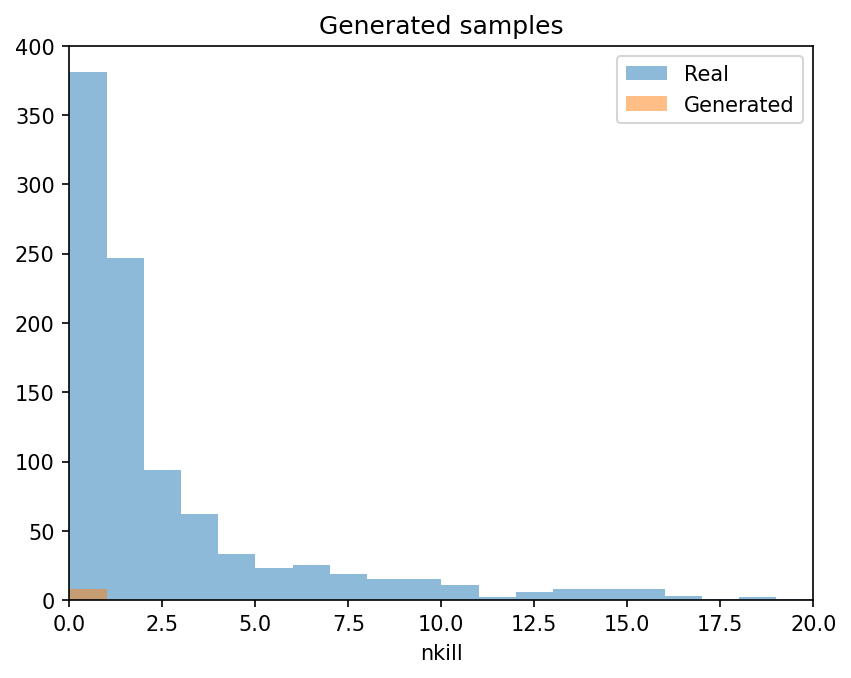

In [56]:
hist_compare(df2['nkill'], data)

As we can see on the chart, generated values matches with real data.
This leads to conclusion, that the samples generated from the prior in model makes sense.
The distribution of the generated samples overlaps with the actual data, however the samples for nkill equal to 0 and 1 are underestimated.

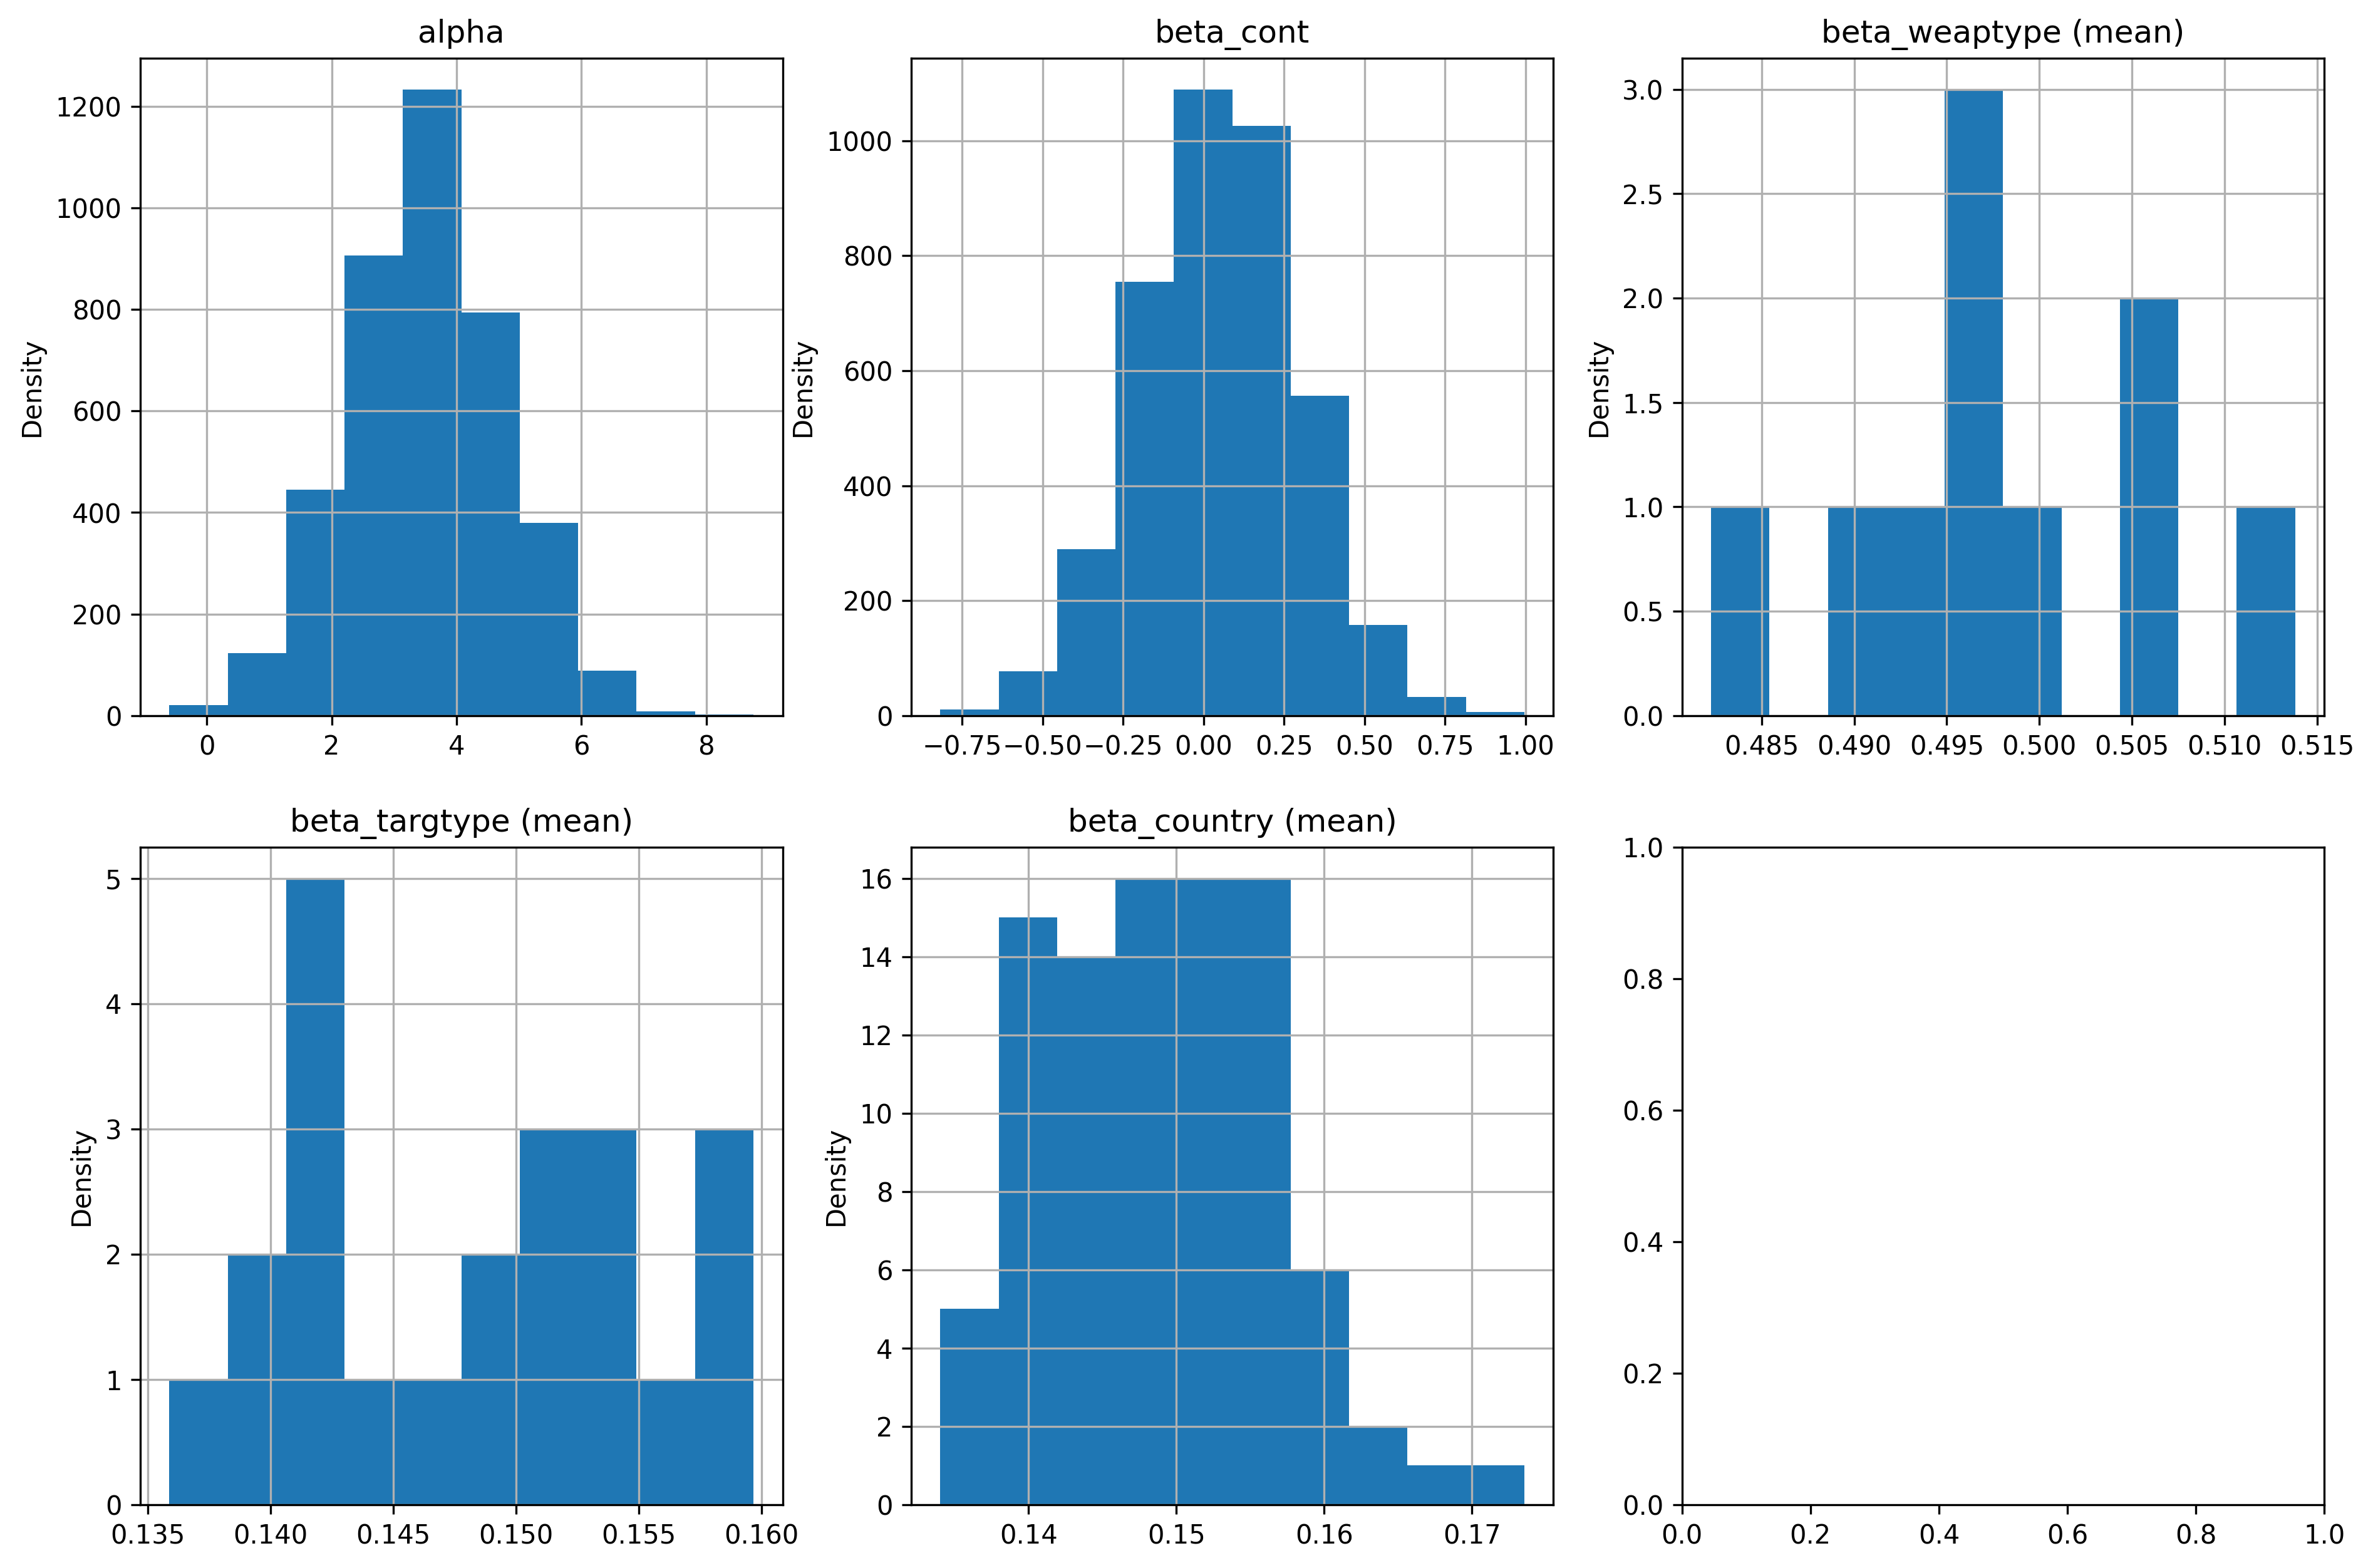

In [12]:
hist_distr_display(df_1_ppc)

Histograms also confirm, that the prior distribution comply with the initial assumptions.

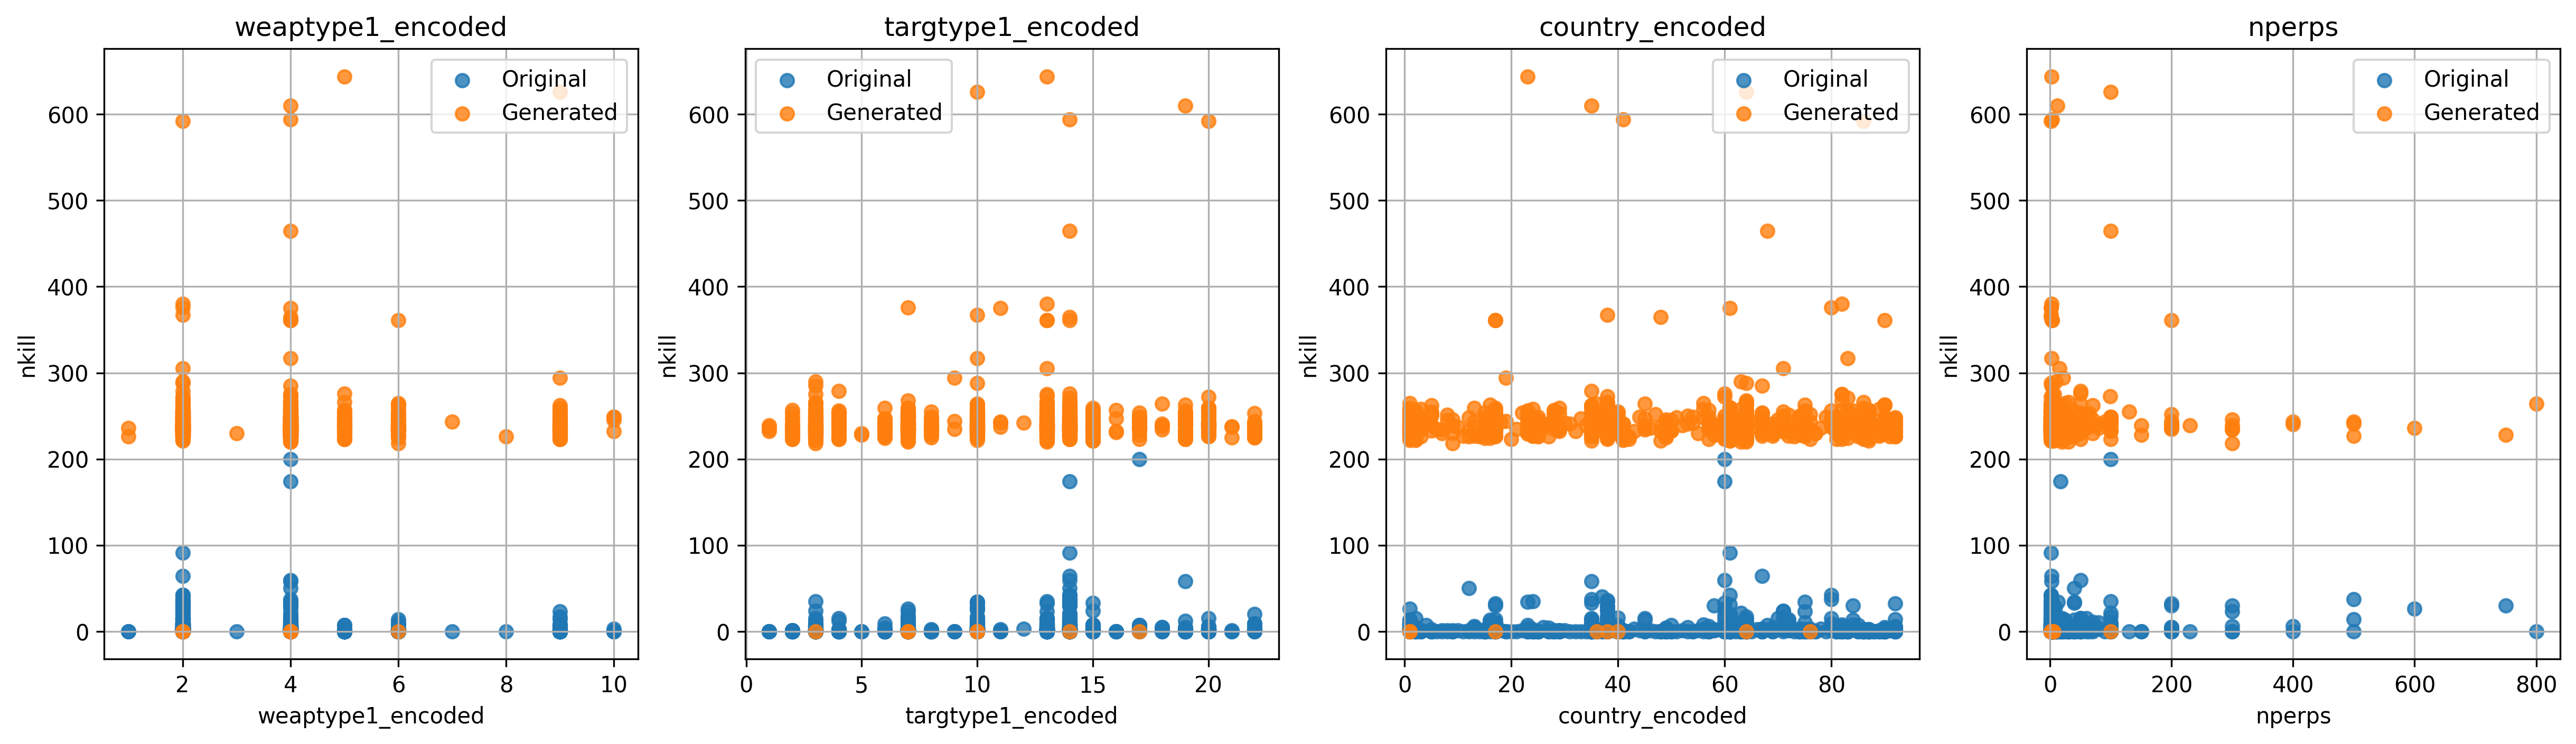

In [57]:
scatter_compare_display(df2[['weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']], df2["nkill"], data)

Once again, generated samples from the prior make sense and align with the initial assumptions.

#### Model 2

In [14]:
model2_ppc = CmdStanModel(stan_file=MODEL_PATH_2_PPC)
sim2_ppc = model2_ppc.sample(
    data=stan_data_pcc,
    seed=SEED,
    chains=4,
    iter_sampling=1000,
    iter_warmup=1000
)

offset = 10 + 1 + 2 + int(weaptype1.max()) + int(targtype1.max()) + int(country.max())
df_2_ppc = sim2_ppc.draws_pd()
data = df_2_ppc.iloc[0][offset:SAMPLES_SIZE+offset]

17:18:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:18:23 - cmdstanpy - INFO - CmdStan done processing.
17:18:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 4.51484e+09, but must be less than 1073741824.000000 (in 'code2_ppc.stan', line 43, column 4 to column 75)
	Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 4.21358e+09, but must be less than 1073741824.000000 (in 'code2_ppc.stan', line 43, column 4 to column 75)
Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 1.22509e+09, but must be less than 1073741824.000000 (in 'code2_ppc.stan', line 43, column 4 to column 75)
	Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 2.32336e+09, but must be less than 1073741824.000000 (in 'code2_ppc.stan', line 43, column 4 to column 75)
Consider re-running with show_console=True if the above output is unclear!


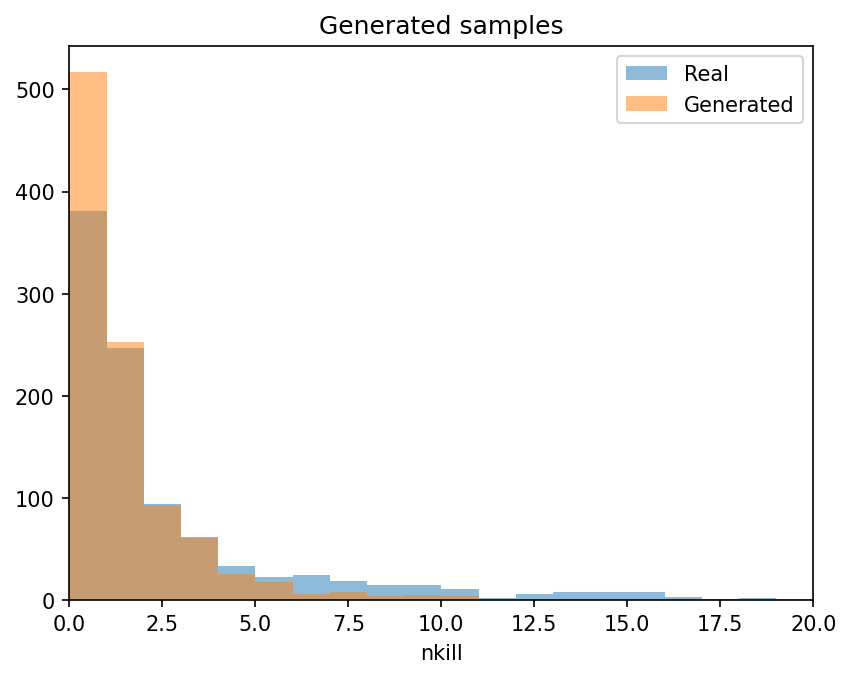

In [15]:
hist_compare(df2['nkill'], data)

As we can see on the chart, generated values matches with real data.
This leads to conclusion, that the samples generated from the prior in model are good, and makes sense.
The distribution of the generated samples overlaps with the actual data, however the samples for nkill equal to 0 are overestimated.

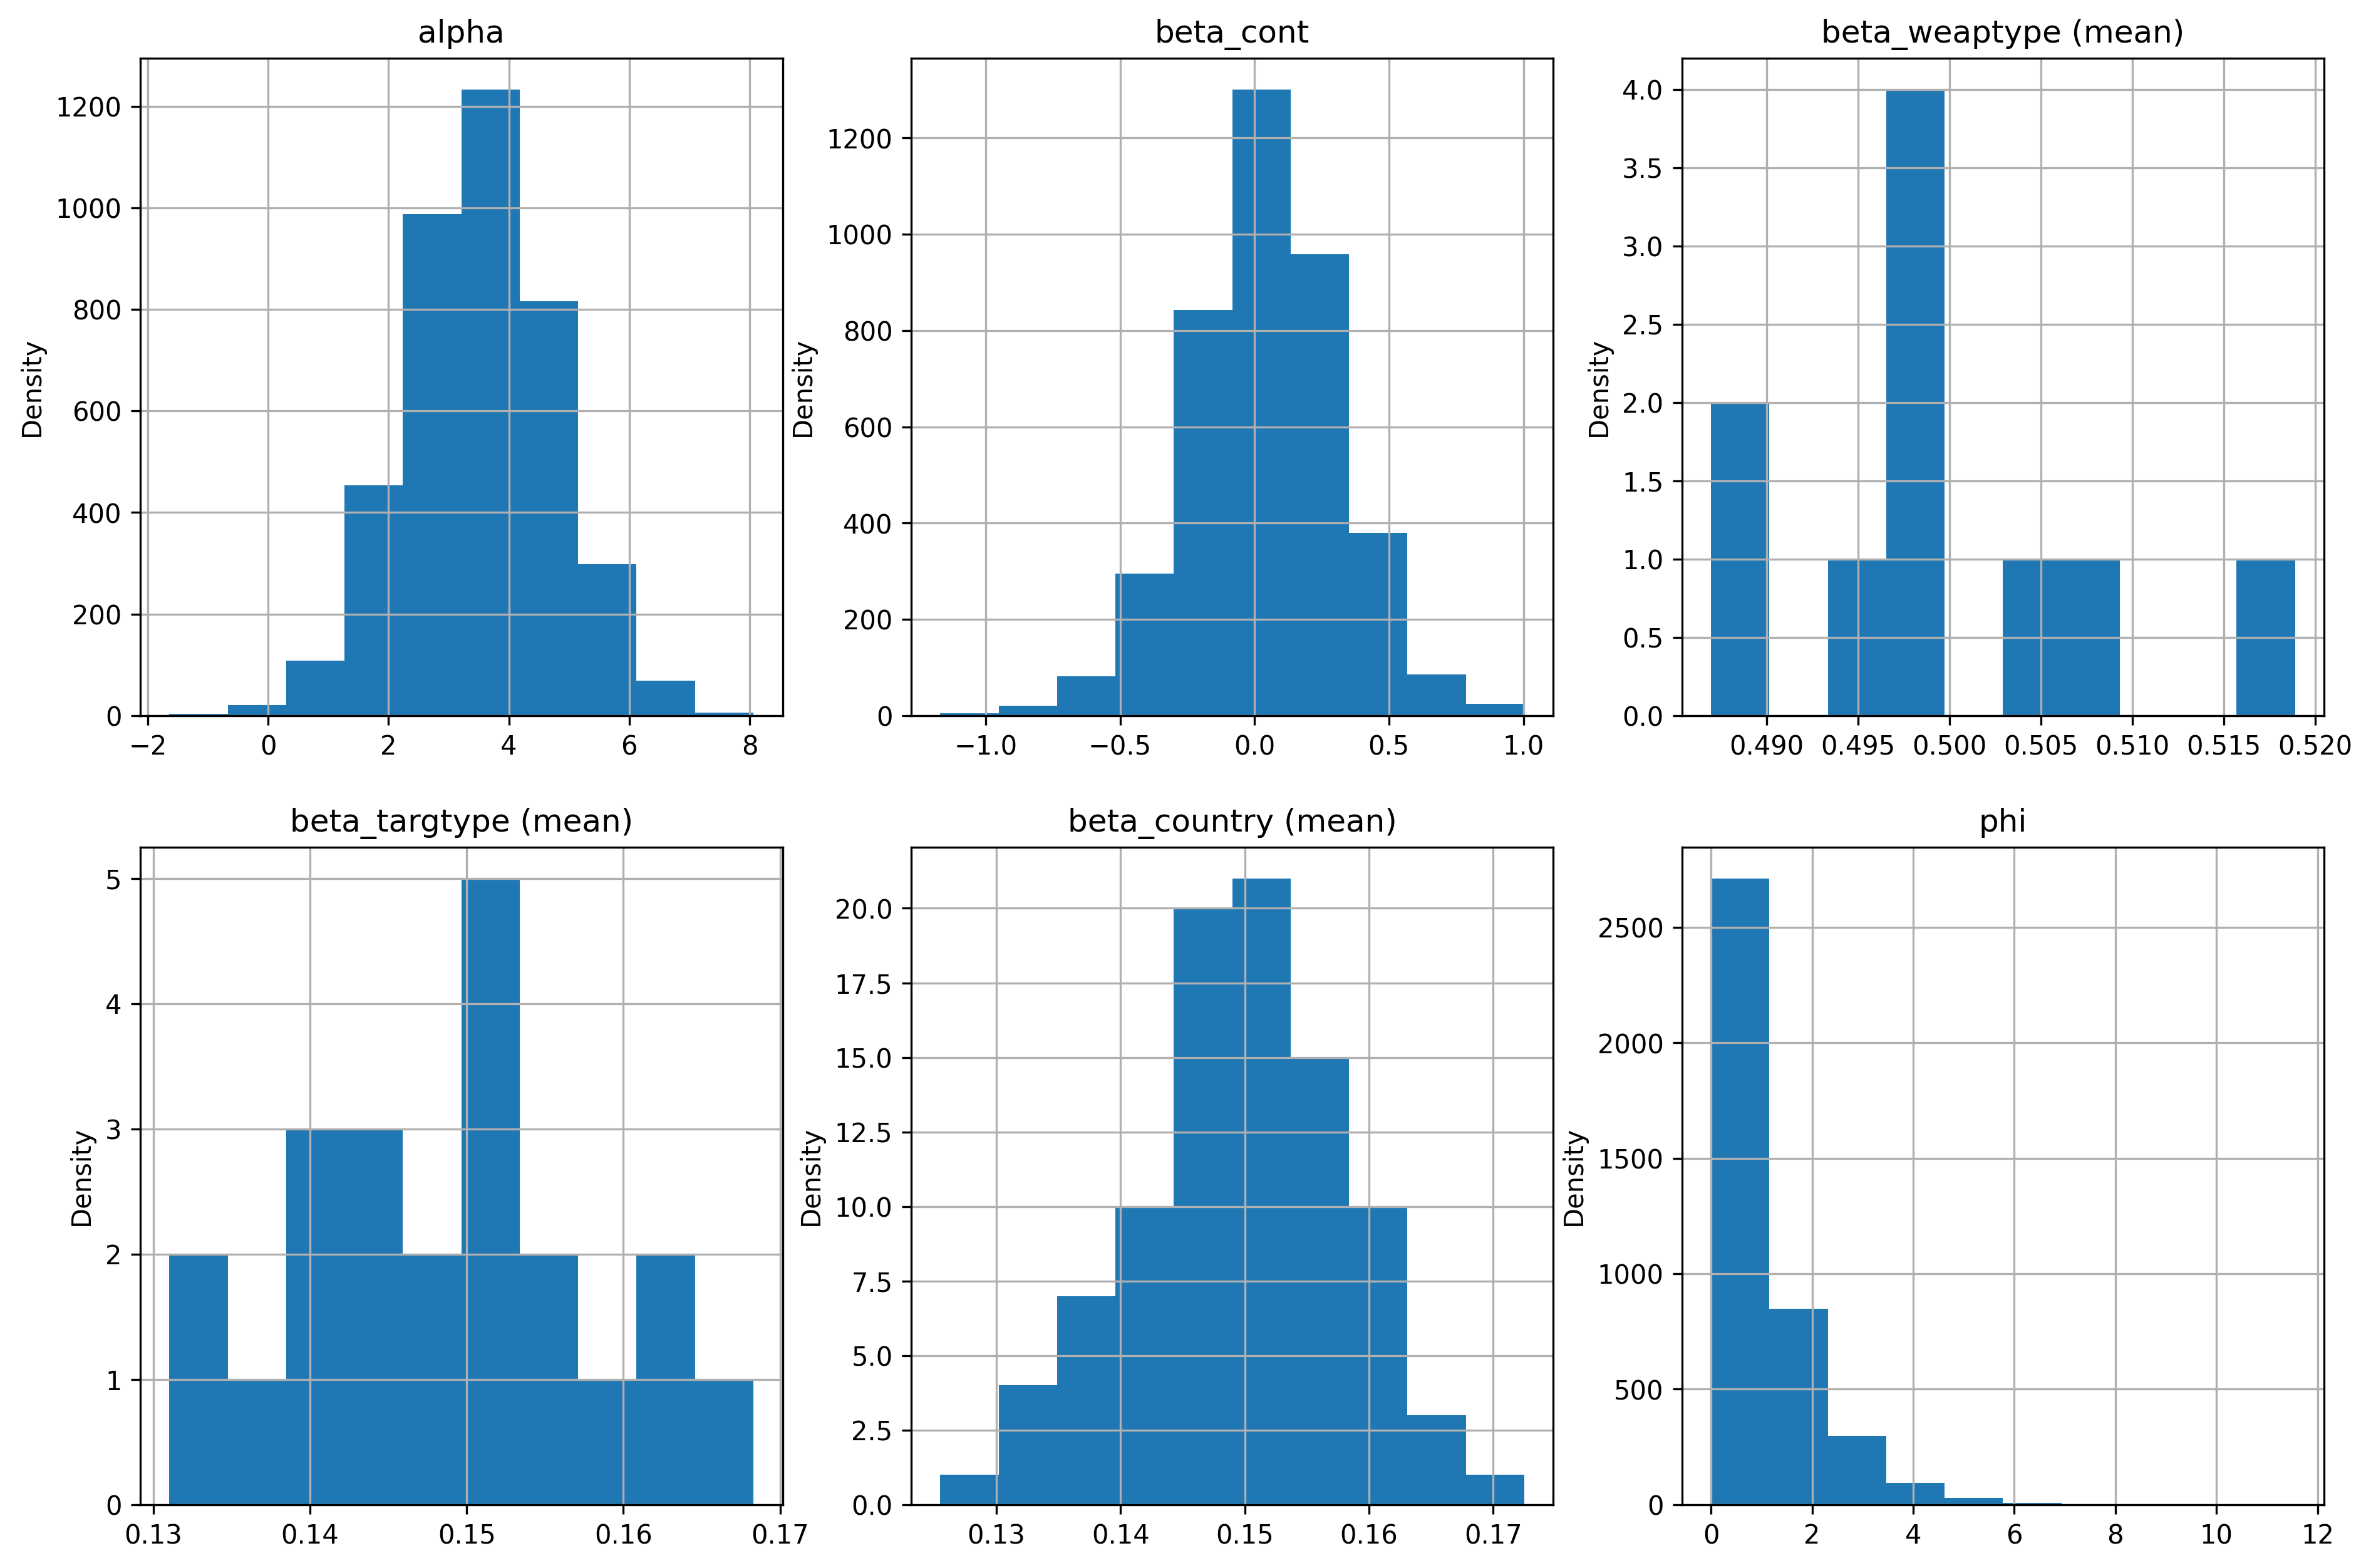

In [16]:
hist_distr_display(df_2_ppc, True)

Histograms also confirm, that the prior distribution comply with the initial assumptions.

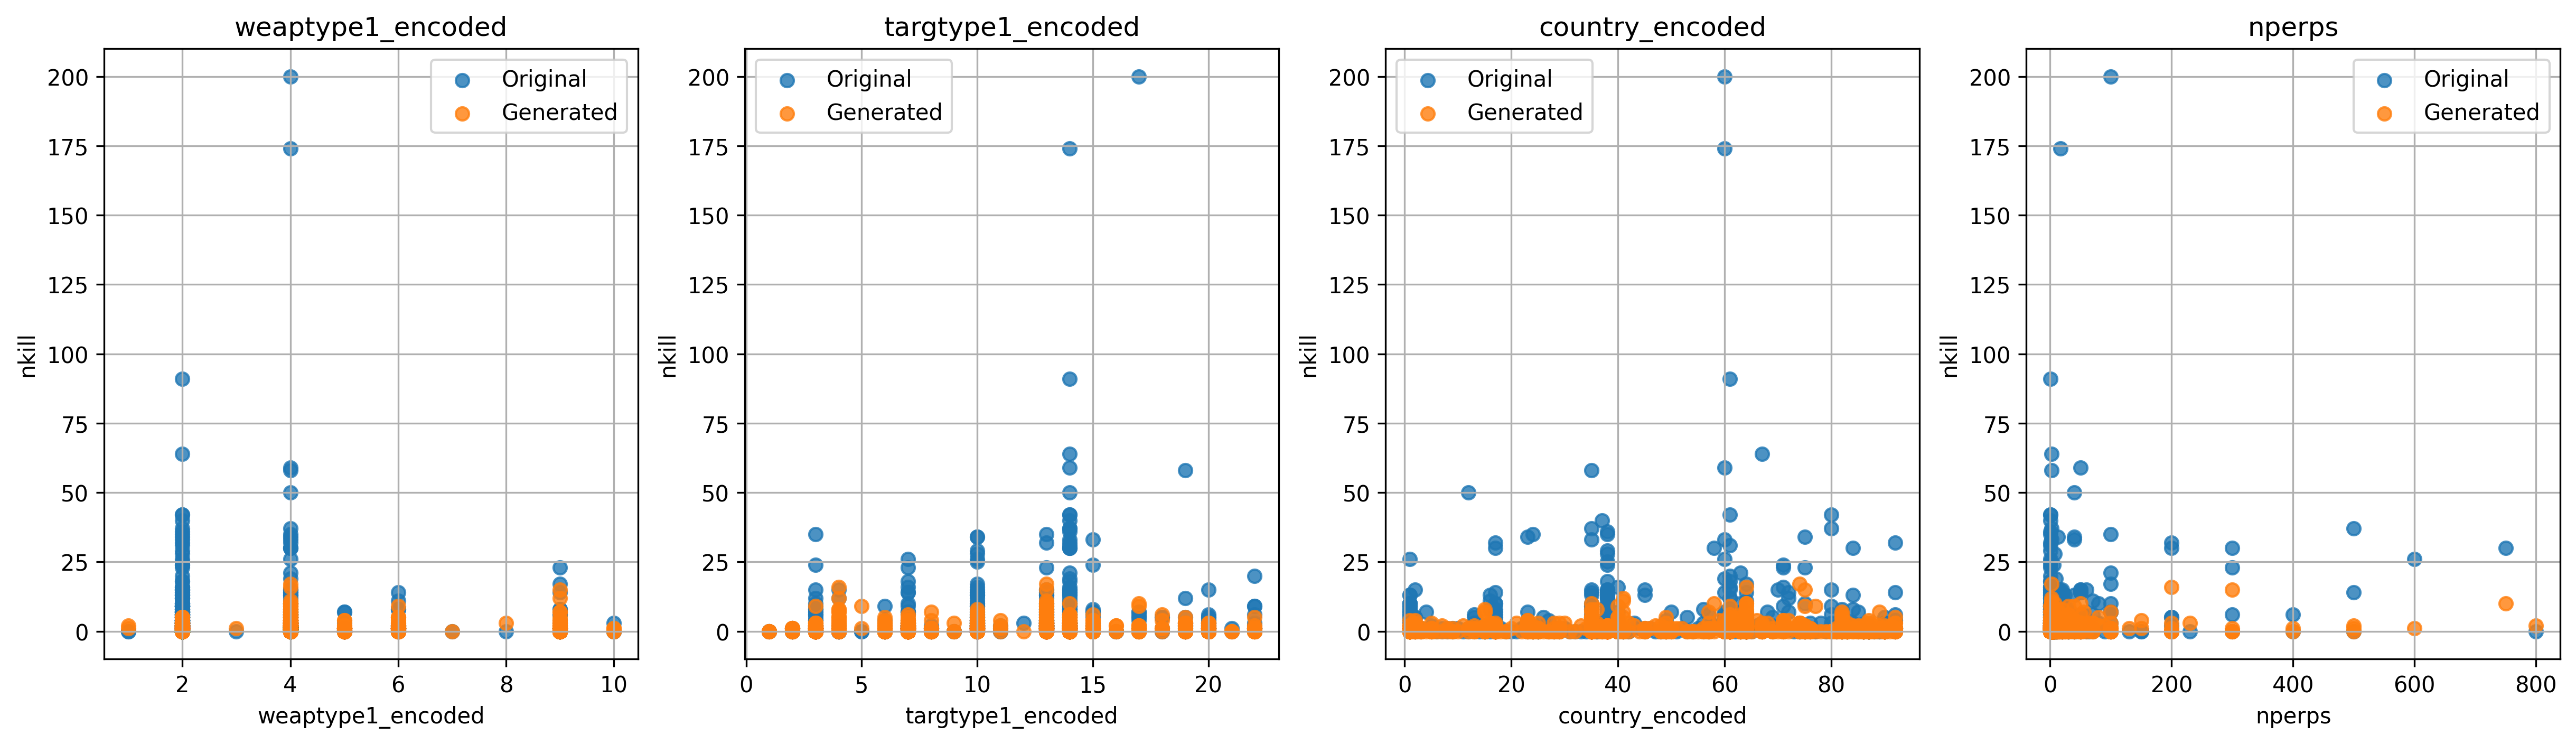

In [17]:
scatter_compare_display(df2[['weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']], df2["nkill"], data)

The generated samples from the prior make sense and align with the initial assumptions.

## 5. Posterior analysis (model 1)

In [18]:
model1 = CmdStanModel(stan_file=MODEL_PATH_1)

sim1 = model1.sample(
    data=stan_data,
    seed=SEED,
    chains=4,
    iter_sampling=2000,
    iter_warmup=1000
)

df_1 = sim1.draws_pd()
offset = 10 + 1 + 1 + int(weaptype1.max()) + int(targtype1.max()) + int(country.max())
data = df_1.iloc[0][offset:SAMPLES_SIZE+offset]

17:18:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:18:48 - cmdstanpy - INFO - CmdStan done processing.


In [19]:
summary_1 = sim1.summary()
display(summary_1[:][offset-9:SAMPLES_SIZE+offset-9])

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
nkill_pred[1],2.31950,0.017244,1.544170,1.4826,0.0,2.0,5.0,8048.12,8008.85,1.00025
nkill_pred[2],5.57925,0.027448,2.624280,2.9652,2.0,5.0,10.0,9252.23,7436.33,1.00015
nkill_pred[3],4.12475,0.023315,2.095770,1.4826,1.0,4.0,8.0,8119.58,7843.70,1.00007
nkill_pred[4],4.65975,0.024213,2.197970,1.4826,1.0,4.0,9.0,8246.46,7680.70,1.00010
nkill_pred[5],2.27888,0.017124,1.558330,1.4826,0.0,2.0,5.0,8389.79,7982.17,1.00038
...,...,...,...,...,...,...,...,...,...,...
nkill_pred[996],2.28938,0.017135,1.533520,1.4826,0.0,2.0,5.0,8005.30,8159.50,1.00017
nkill_pred[997],0.90150,0.010584,0.960163,1.4826,0.0,1.0,3.0,8184.27,7967.37,1.00001
nkill_pred[998],15.54730,0.045495,4.132420,4.4478,9.0,15.0,23.0,8255.63,7976.07,1.00004
nkill_pred[999],4.60600,0.024647,2.215820,1.4826,1.0,4.0,9.0,8143.60,7590.23,1.00018


All R‑hat values were approximately 1.00, and effective sample sizes (both bulk and tail) were satisfactory across all parameters. No divergent transitions were detected, indicating good mixing and convergence of the chains.

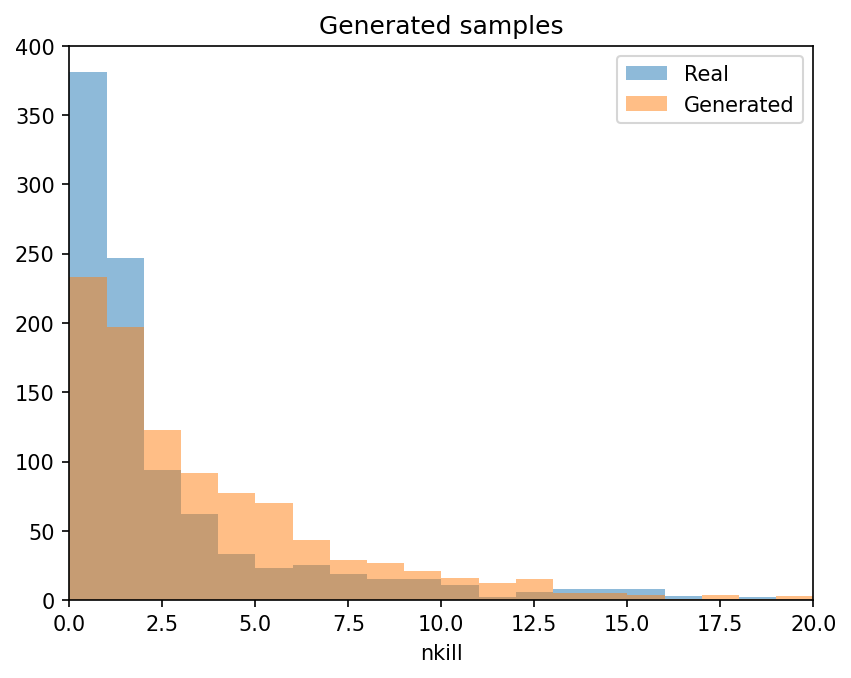

In [20]:
hist_compare(df2['nkill'], data)

From the above histogram, it can be concluded that the posterior model is able to describe the observed data.
On the other hand, the model may still be imperfect and capable of producing numbers that are either slightly overestimated or totally underestimated.
Because the model was not restricted, smooth sampling was possible, but the outcome (the generated data) was influenced.

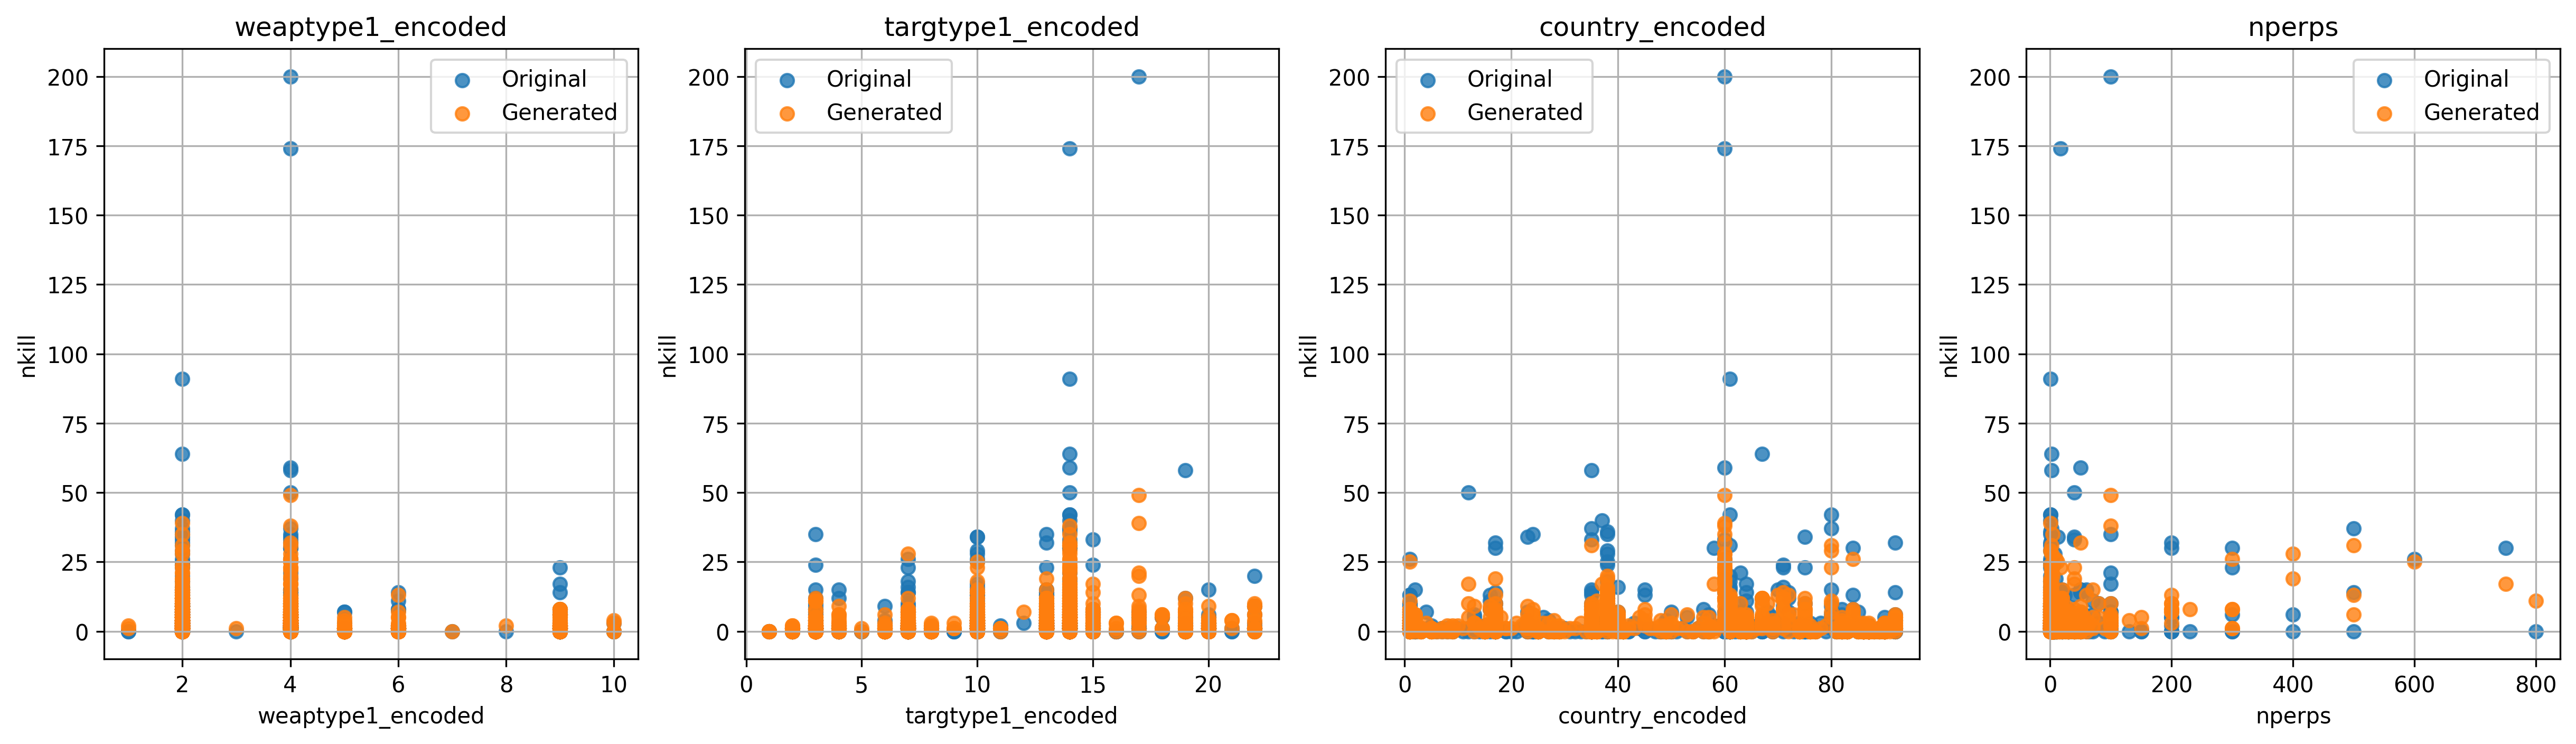

In [21]:
scatter_compare_display(df2[['weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']], df2["nkill"], data)

From the scatter plots above, it is evident that the model can produce plausible samples. 
It is also apparent that the posterior model can generate more extreme values within the same range than the prior model. 
This implies that the posterior model has not only learned the data, but is also able to produce samples that represent the variations in the observed data.

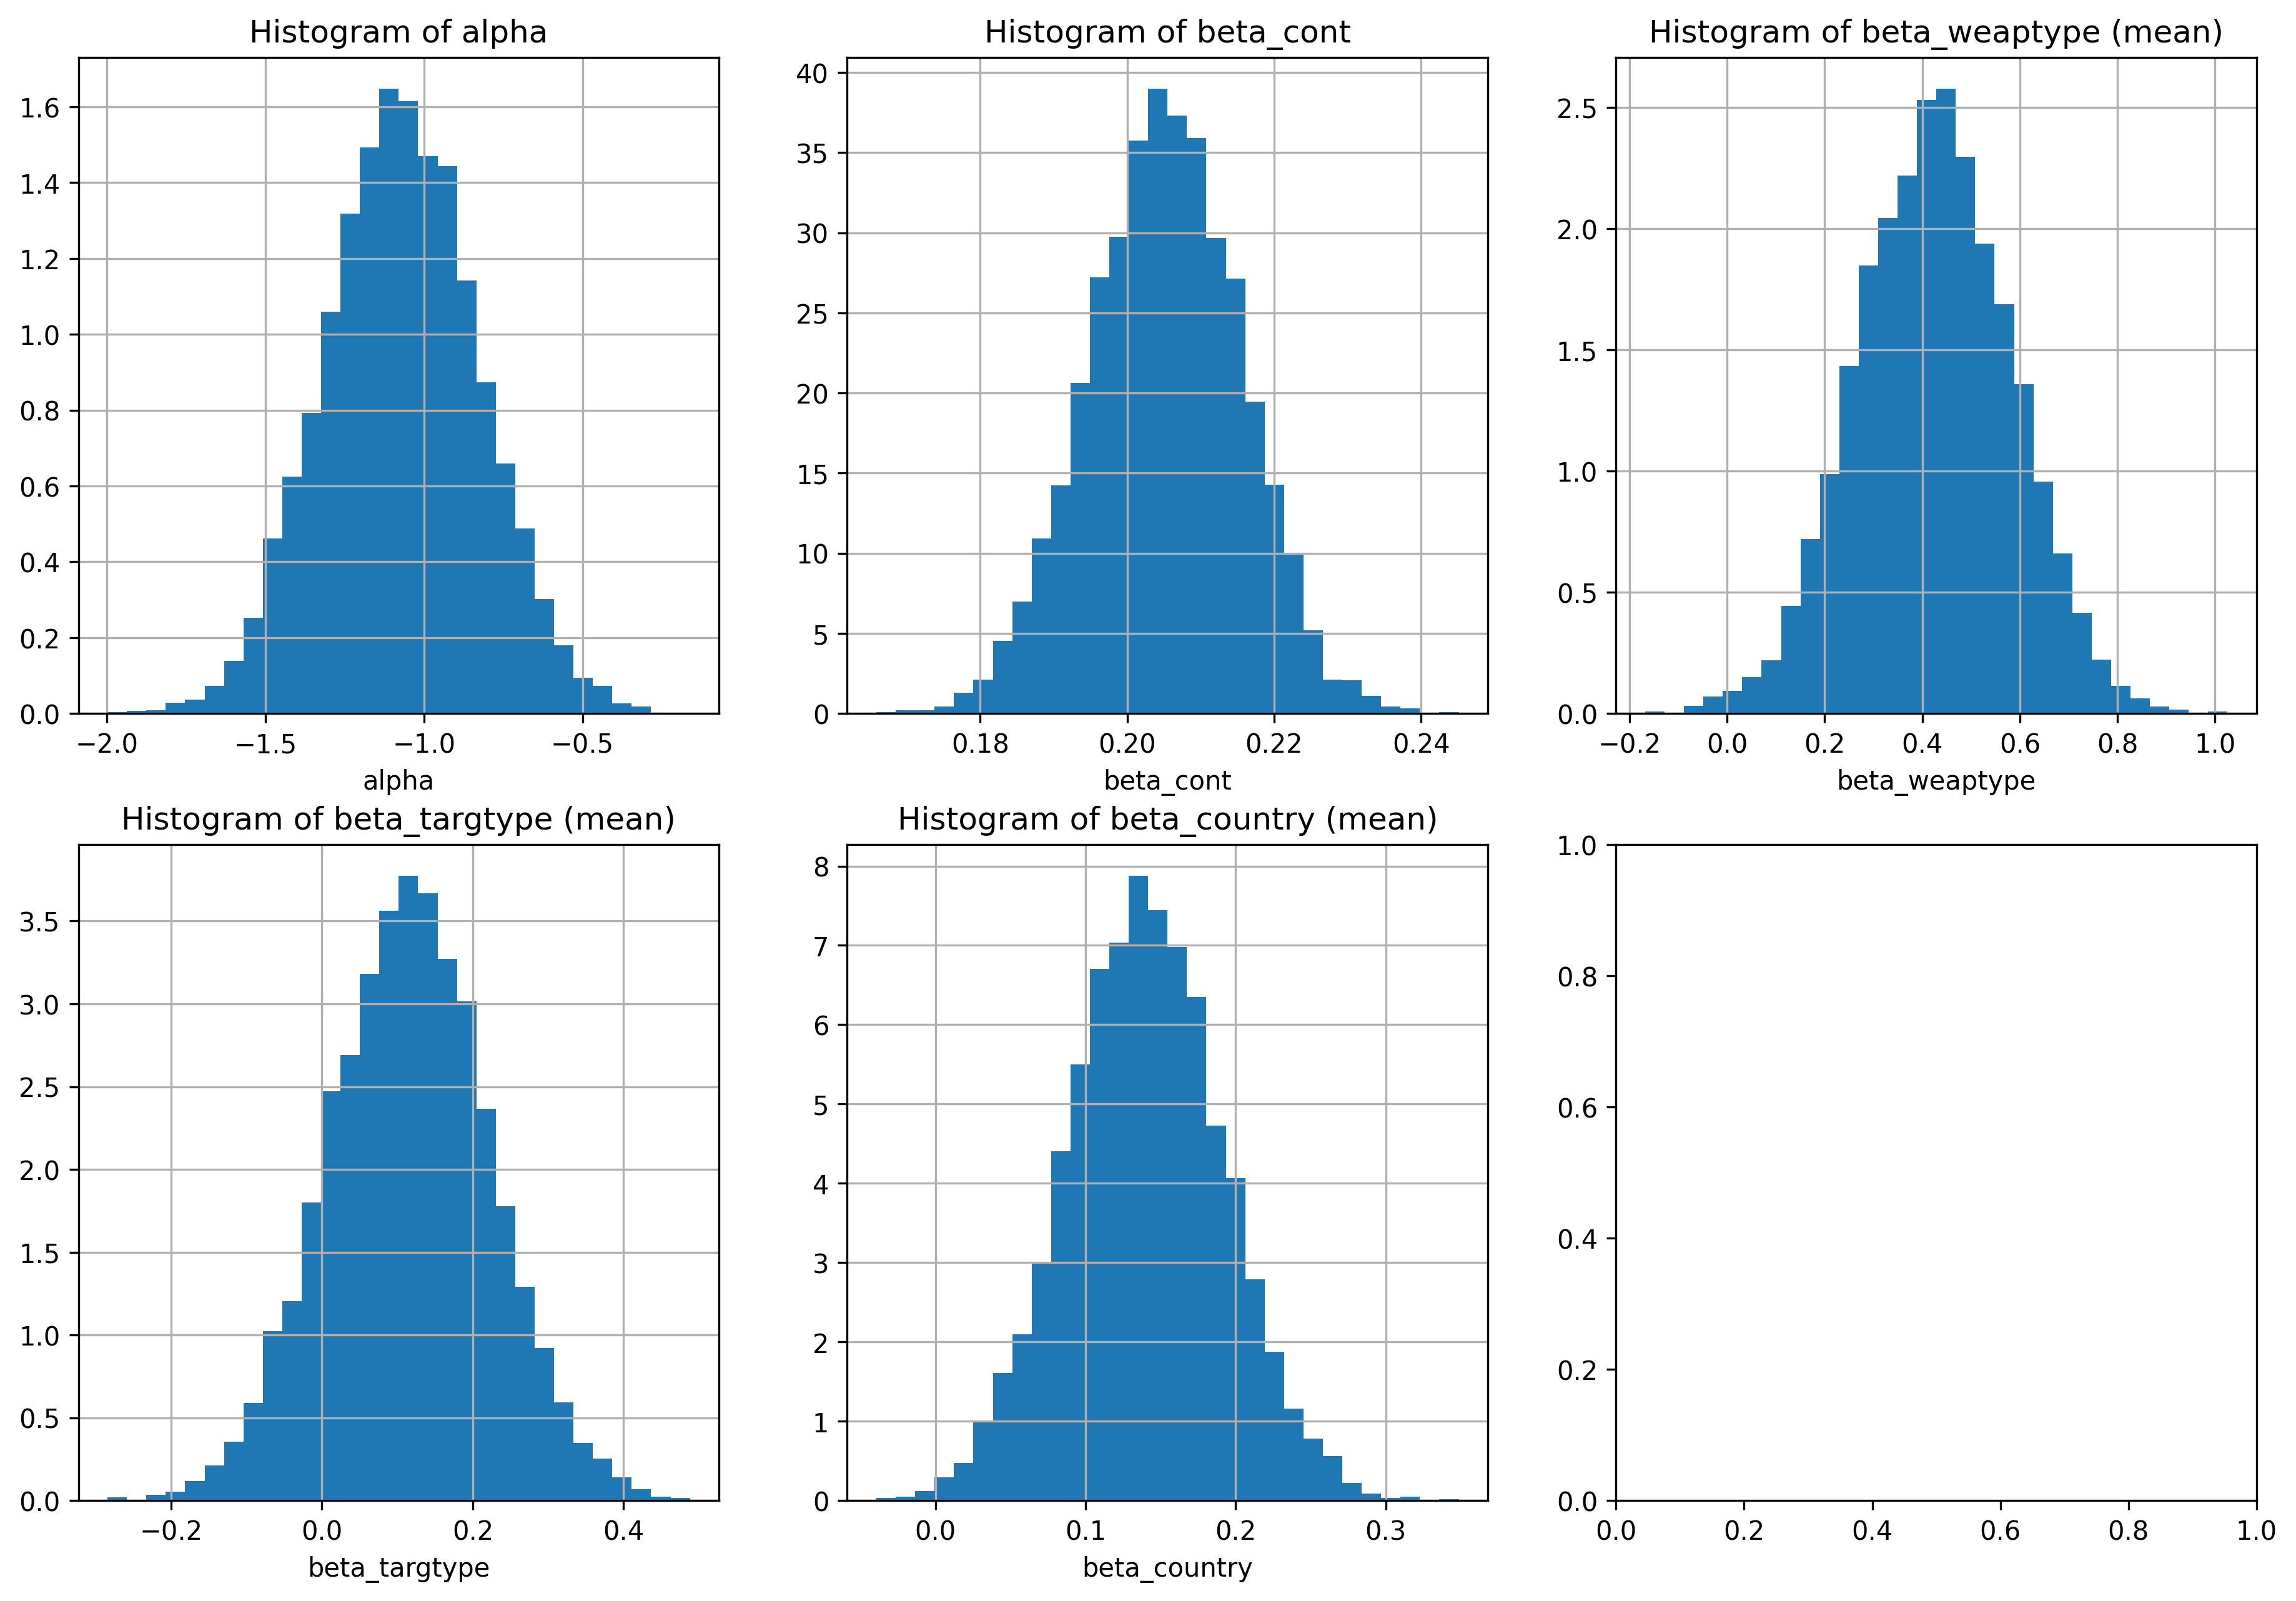

In [22]:
hist_disr_posterior_display(sim1)

The histograms plotted form the generated data confirm that the posterior distributions are consistent with the prior assumptions.
The posterior model parameters are different from our priors, hence, it is safe to say that the model has learned from the real data  and adjusted its parameters accordingly.

## 6. Posterior analysis (model 2)

In [23]:
model2 = CmdStanModel(stan_file=MODEL_PATH_2)

sim2 = model2.sample(
    data=stan_data,
    seed=SEED,
    chains=4,
    iter_sampling=2000,
    iter_warmup=1000
)

df_2 = sim2.draws_pd()
offset = 10 + 1 + 2 + int(weaptype1.max()) + int(targtype1.max()) + int(country.max())
data = df_2.iloc[0][offset:SAMPLES_SIZE+offset]

17:19:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:19:29 - cmdstanpy - INFO - CmdStan done processing.
17:19:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be positive finite! (in 'code2.stan', line 41, column 2 to column 46)
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be positive finite! (in 'code2.stan', line 41, column 2 to column 46)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code2.stan', line 41, column 2 to column 46)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code2.stan', line 41, column 2 to column 46)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code2.stan', line 41, column 2 to column 46)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'code2.stan', line 41, column 2 to column 46)
Exception: neg_binomial_2_

In [24]:
summary_2 = sim2.summary()
display(summary_2[:][offset-9:SAMPLES_SIZE+offset-9])

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
nkill_pred[1],2.12188,0.035980,3.13089,1.4826,0.0,1.0,9.0,7533.85,7277.84,1.000280
nkill_pred[2],5.00563,0.081986,7.57371,2.9652,0.0,2.0,19.0,8213.34,7897.98,1.000250
nkill_pred[3],5.49962,0.086425,7.69494,4.4478,0.0,3.0,21.0,7972.89,7935.32,0.999796
nkill_pred[4],3.93475,0.063519,5.59354,2.9652,0.0,2.0,15.0,7548.23,7647.91,0.999778
nkill_pred[5],2.89950,0.050509,4.48008,1.4826,0.0,1.0,12.0,7658.08,7515.38,1.000530
...,...,...,...,...,...,...,...,...,...,...
nkill_pred[996],1.95725,0.033298,2.93726,1.4826,0.0,1.0,8.0,7838.83,7134.52,1.000000
nkill_pred[997],1.07212,0.020879,1.89674,0.0000,0.0,0.0,5.0,8265.85,8086.29,0.999769
nkill_pred[998],6.49763,0.104310,9.31428,4.4478,0.0,3.0,25.0,7890.93,7841.37,1.000190
nkill_pred[999],5.21762,0.083199,7.27495,4.4478,0.0,3.0,20.0,7982.27,7732.07,0.999762


All R‑hat values were approximately 1.00, and effective sample sizes (both bulk and tail) were satisfactory across all parameters. No divergent transitions were detected, indicating good mixing and convergence of the chains. 
However, a few times an error occurs, indicating that the precision parameter (Phi) is 0, but must be positive finite. 
Despite that we decided to stay with this model and parameters.

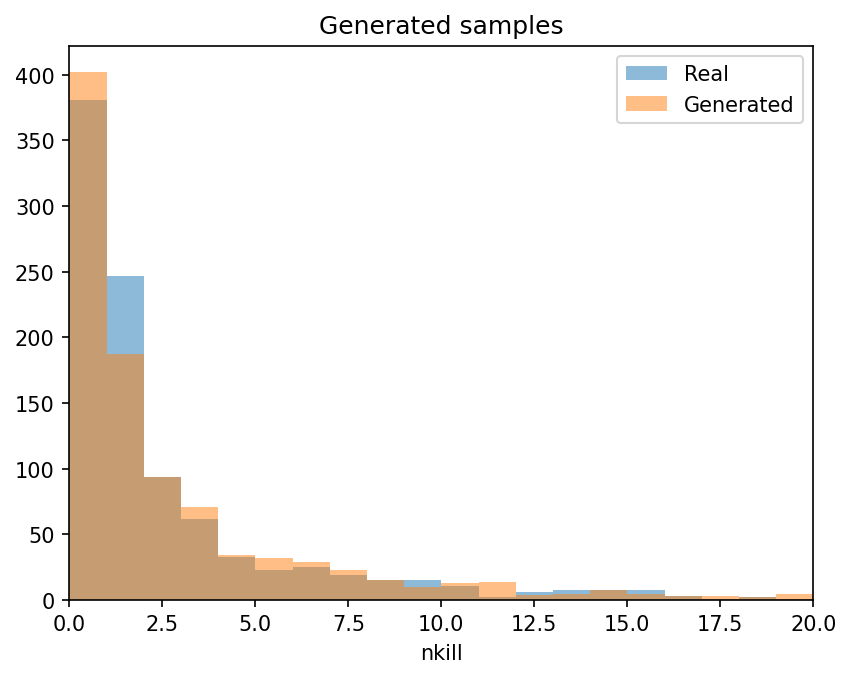

In [25]:
hist_compare(df2['nkill'], data)

From the histogram, it can be concluded that the posterior model is able to describe the observed data.
The model seems to be valid, however some samples are overestimated and some are underestimated.
The model have one constrain, the Phi parameter must be non-negative.
What is more, the model can overestimate extreme values, as we can see, the model is eager to generate more cases above 10 victims.

It is important to note that the data generated by model is more dispersed.
This could lead to that model provides more high, rare data, than happened in real world.

In comparison to first model, this model better fits the real data for 0 and 1 facilities cases, where the rest is nearly identical.

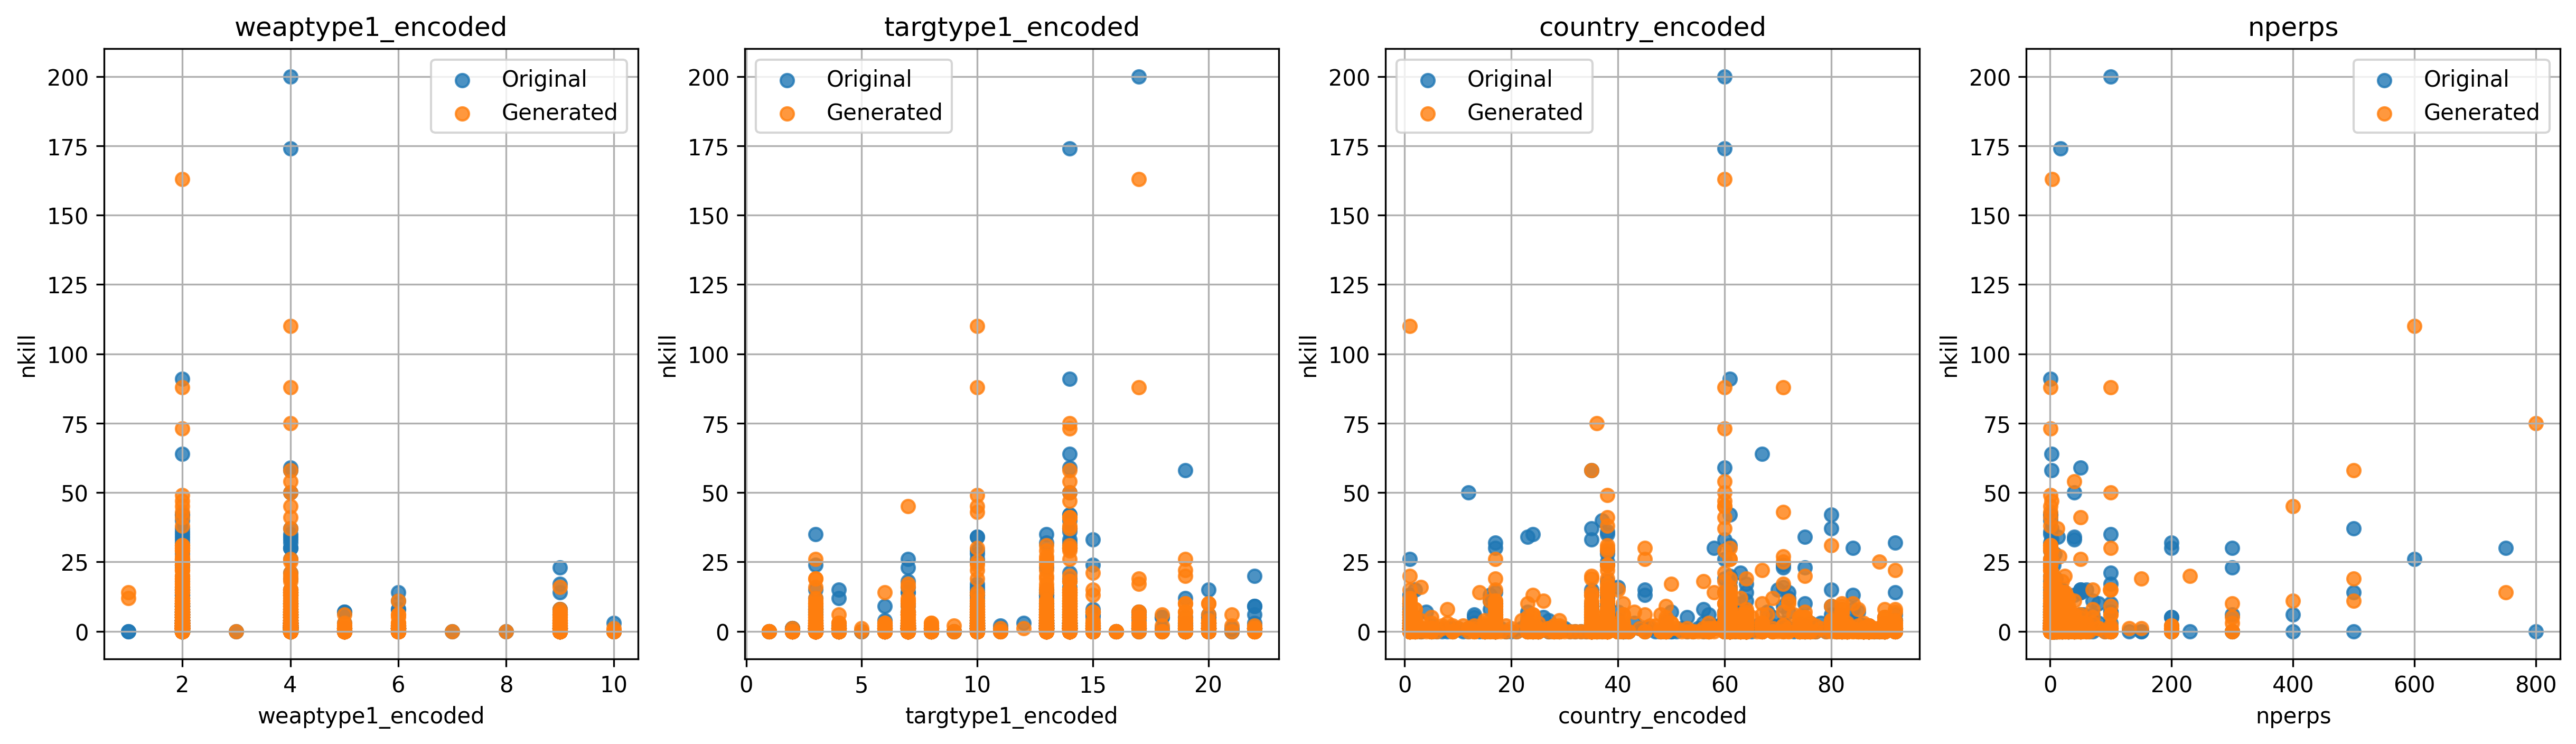

In [26]:
scatter_compare_display(df2[['weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']], df2["nkill"], data)

From the scatter plots, we can observe the model can generate valid data, which matches with the real one.
This suggests that the posterior model has learned from the data and is able to generate samples that can capture variability in the real data.
In comparison to first model, second model learned even better to the real data.
Also this model is more eager to produce high nkill samples.

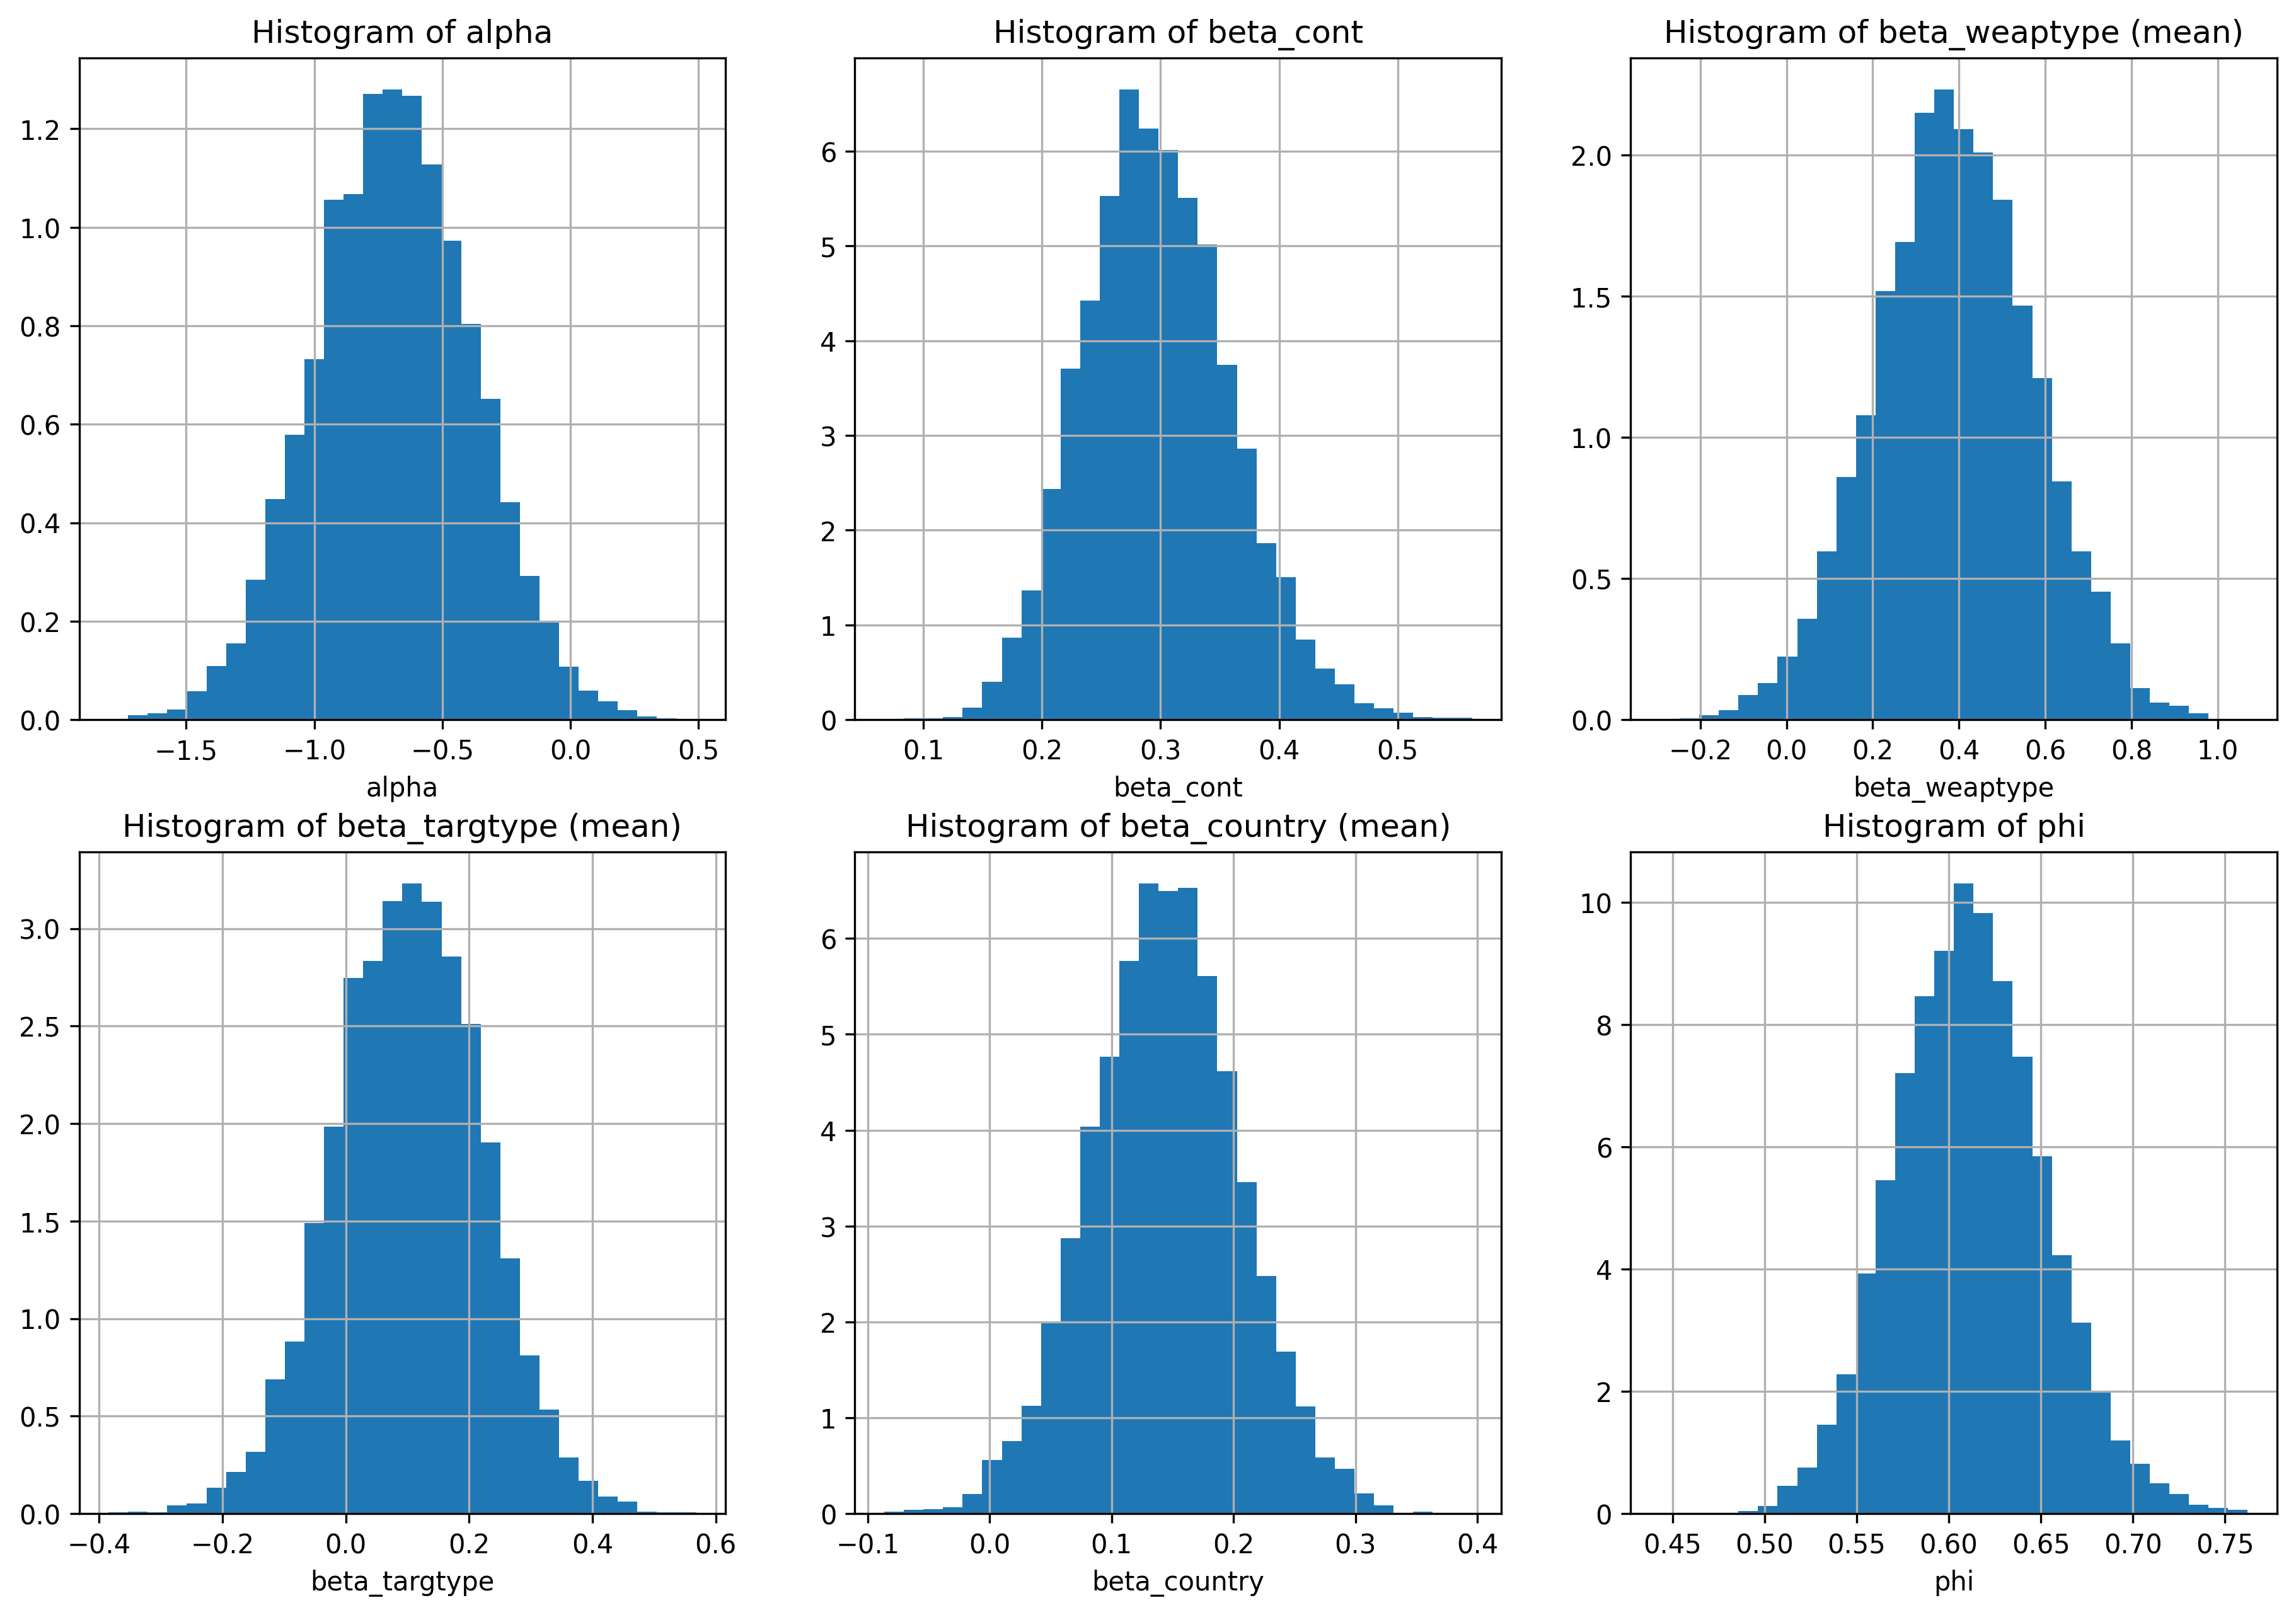

In [27]:
hist_disr_posterior_display(sim2, True)

The histograms plotted form the generated data confirm that the posterior distributions are consistent with the prior assumptions.
The posterior model parameters are different from our priors, hence, it is safe to say that the model has learned from the real data  and adjusted its parameters accordingly.
Likewise the first model.

## 7. Model comparison

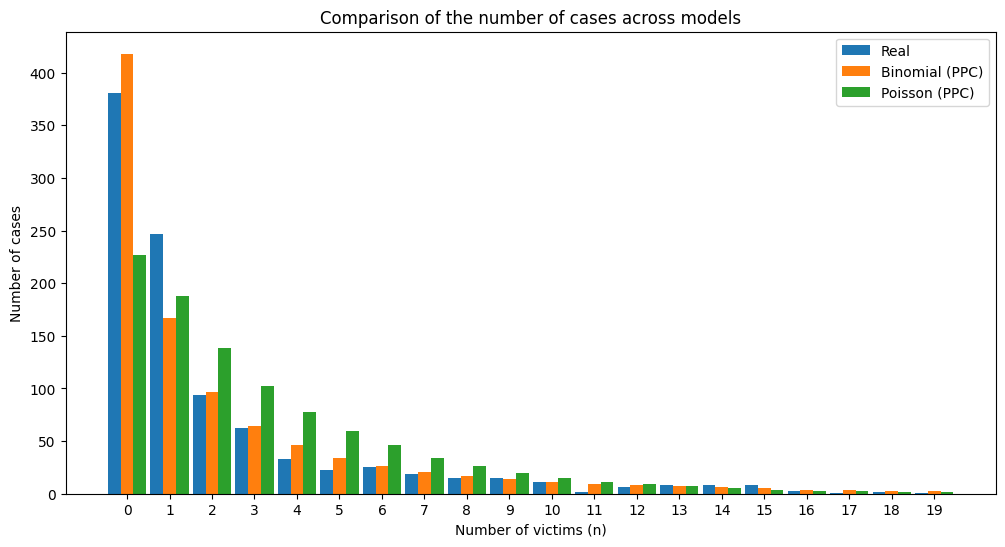

In [28]:
n_values = np.arange(0, 20)
true_counts = []
binomial_counts = []
poisson_counts = []

for n in n_values:
    true_count = np.sum(df2["nkill"].values == n)
    poisson_count = int(np.round(np.sum(df_1[list(df_1.filter(regex=r"nkill_pred\[\d+\]").columns)] == n, axis=1).mean()))
    binomial_count = int(np.round(np.sum(df_2[list(df_2.filter(regex=r"nkill_pred\[\d+\]").columns)] == n, axis=1).mean()))

    true_counts.append(true_count)
    binomial_counts.append(binomial_count)
    poisson_counts.append(poisson_count)


bar_width = 0.3
index = np.arange(len(n_values))

plt.figure(figsize=(12,6))
plt.bar(index - bar_width, true_counts, bar_width, label='Real')
plt.bar(index, binomial_counts, bar_width, label='Binomial (PPC)')
plt.bar(index + bar_width, poisson_counts, bar_width, label='Poisson (PPC)')

plt.xlabel('Number of victims (n)')
plt.ylabel('Number of cases')
plt.xticks(index, n_values)
plt.legend()
plt.title('Comparison of the number of cases across models')
plt.show()

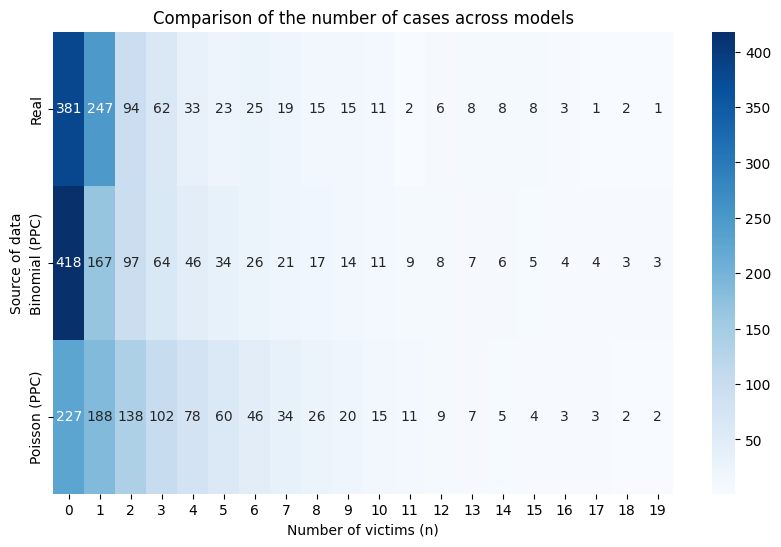

In [29]:
df_heatmap = pd.DataFrame({
    'n': n_values,
    'Real': true_counts,
    'Binomial (PPC)': binomial_counts,
    'Poisson (PPC)': poisson_counts
}).set_index('n')

plt.figure(figsize=(10,6))
sns.heatmap(df_heatmap.T, annot=True, fmt='d', cmap='Blues')
plt.title('Comparison of the number of cases across models')
plt.xlabel('Number of victims (n)')
plt.ylabel('Source of data')
plt.show()

#### LOO Comparison

In [30]:
model1_info = az.from_cmdstanpy(sim1)
model2_info = az.from_cmdstanpy(sim2)

models_dict = {
    "model1": model1_info,
    "model2": model2_info,
}
loo_comparison = az.compare(models_dict, ic="loo", scale="negative_log")
display(loo_comparison)

/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model2,0,2044.039176,68.143413,0.000000,0.986551,52.127360,0.000000,True,negative_log
model1,1,4238.238979,599.405500,2194.199803,0.013449,392.305399,358.879127,True,negative_log


During the LOO compare, some warning occured. 
The warnings are about the same issue, the shape of Pareto distribution is greater than 0.7 for one or more samples. 
This means that model has problematic influential observations that are making LOO unreliable, probably due to a few observations that does not meet the model assumptions, and this could lead to misleading conclusions.

In [31]:
az.loo(model1_info, pointwise=True)

/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 8000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4238.24   392.31
p_loo      599.41        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      965   96.5%
   (0.70, 1]   (bad)        19    1.9%
   (1, Inf)   (very bad)   16    1.6%

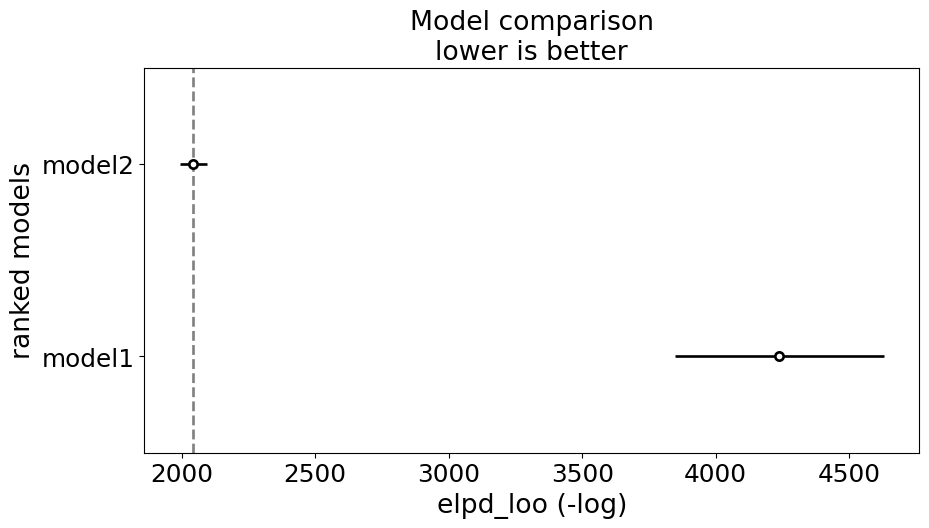

In [32]:
az.plot_compare(loo_comparison, figsize=(10, 5))
plt.show()

As we can see on the chart, the second model is better and achives the lower score, which places the model higher in the ranking.

#### WAIC Comparison

In [33]:
waic_comparison = az.compare(models_dict, ic="waic", scale="negative_log")
display(waic_comparison)

/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model2,0,2039.101529,63.205765,0.000000,0.981423,51.364173,0.000000,True,negative_log
model1,1,4342.438865,703.605386,2303.337336,0.018577,439.160855,407.438359,True,negative_log


During the waic compare, there were warnings messages that indicated the posterior variance of the log predictive densities exceeds 0.4.
This means that model is very uncertain about its prediction, and hence, WAIC becomes an unreliable criterion for comparing models.

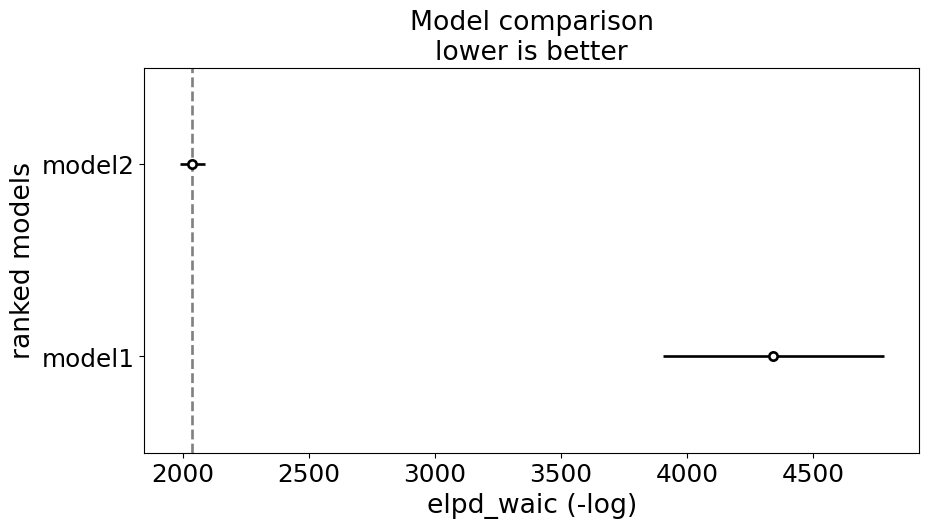

In [34]:
az.plot_compare(waic_comparison, figsize=(10, 5))
plt.show()

Similar to LOO criterium, model 2 again is better. 
It has better score and so higher rank.

Taking into account the individual results and charts for Model 1 and Model 2, as well as considering the parameters for comparing these models, we can conclude that Model 2, which include different likelihood and priors distribution, is better and more accurately reflects the real data. Thus, we agree with the ranking of models presented by the LOO and WAIC criteria. Our hypothesis, why the second model is superior is that, the negative binomial distribution is more appropriate for the data's characteristics. The Poisson model, which assumes the the mean and variance of the counts are equal, is not the case with the Negative Binomial model that allows for overdispersion, a situation typical in data where there are rare but very significant events. The number of casualties in out instance exhibits pronounced fluctuation, with many small numbers and few highly unusual ones. The Negative Binomial model is more consistent with such behavior, thus a better fit and more accurate prediction performance, as shown by lower LOO and WAIC scores are observed.

To sum up, the naive binomial model performs better in the problem of predicting the number of casualties in terrorist attacks. Both the priors and posteriors fitted the data more accurately. The Poisson model struggled to correctly estimate cases where nkill equals 0 or 1, although it performed reasonably well in other cases.